In [1]:
import statsmodels.api as stm
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
import numpy as np
from datetime import datetime
import statsmodels.graphics.tsaplots as sgt
from arch import arch_model
import warnings
from sklearn.metrics import mean_squared_error


In [2]:
def carga_datos_seleccionados():
    df1 = pd.read_csv('Datos/Transformados/diarios/JPM_marketstack.csv', index_col='date')
    df2 = pd.read_csv('Datos/Transformados/diarios/CAT_marketstack.csv',index_col='date')
    df3 = pd.read_csv('Datos/Transformados/diarios/GS_marketstack.csv',index_col='date')
    df1.index = pd.to_datetime(df1.index, format='%Y-%m-%d').date
    df2.index = pd.to_datetime(df2.index, format='%Y-%m-%d').date
    df3.index = pd.to_datetime(df3.index, format='%Y-%m-%d').date
    return df1, df2, df3

In [3]:
df1, df2, df3 = carga_datos_seleccionados()

In [4]:
df1.head()

close_cubic
2020-06-01    97.310000
2020-06-02    98.600000
2020-06-03    99.762098
2020-06-04   104.270000
2020-06-05   106.440000

In [5]:
#Cambiar nombre de columna de close_cubic a clos
for df in [df1, df2, df3]:
    df.rename(columns={'close_cubic':'close'}, inplace=True)

### Normalizar los datos

Se normalizan los datos para que el tamaño de la empresa no afecte en el los cálculos.

In [6]:
def normalizar(df1,df2,df3):
    df1['close'] = df1['close']/df1['close'][0]
    df2['close'] = df2['close']/df2['close'][0]
    df3['close'] = df3['close']/df3['close'][0]
    return df1, df2, df3

df1, df2, df3 = normalizar(df1, df2, df3)

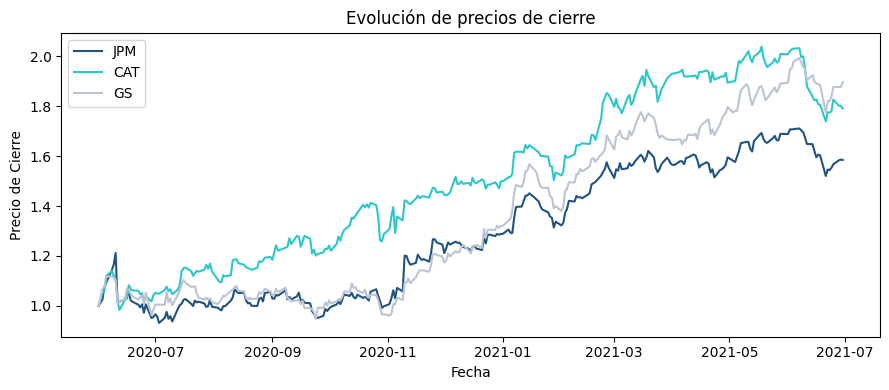

In [7]:
def evolucion_close(df1, df2, df3):
    fig, ax = plt.subplots(figsize=(9, 4))

    # Define una paleta de colores personalizada
    colores = ['#225380', '#2DC7C9', '#BCC4D4']

    df1['close'].plot(label='JPM', color=colores[0])
    df2['close'].plot(label='CAT', color=colores[1])
    df3['close'].plot(label='GS', color=colores[2])

    ax.set_title('Evolución de precios de cierre')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Precio de Cierre')
    plt.legend()

    plt.tight_layout()
    plt.show()

evolucion_close(df1, df2, df3)

### Suavizado de la serie

* Media móvil

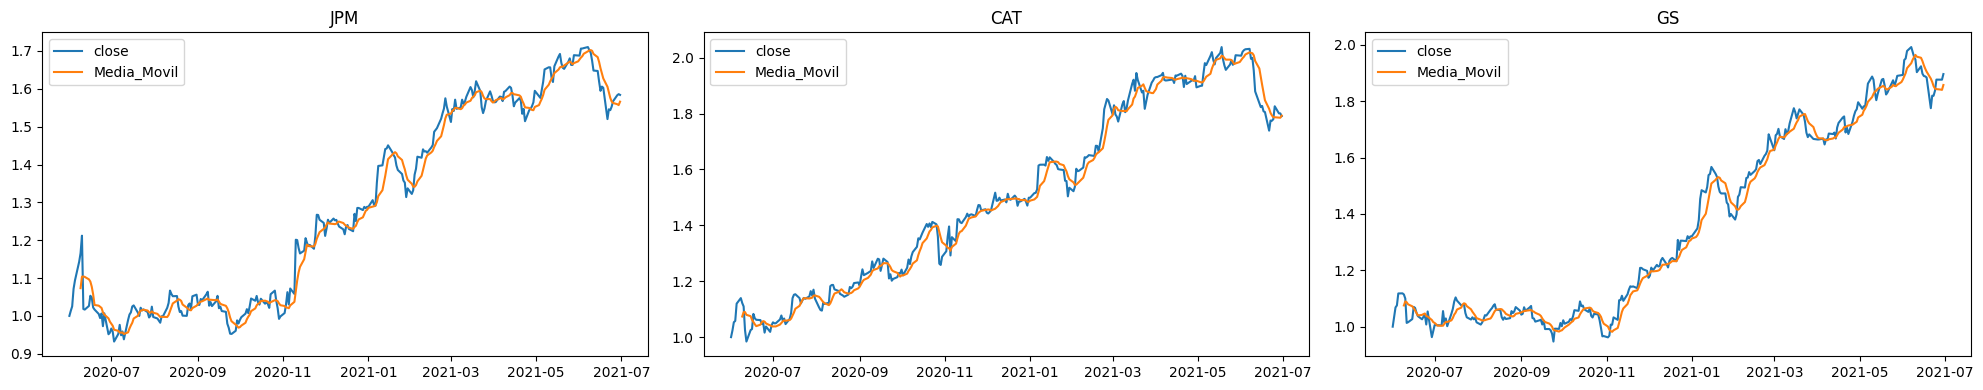

In [8]:
def evolucion_media_movil(df1, df2, df3):
    fig, axs = plt.subplots(1, 3, figsize=(20, 4))

    df1_suave = df1.copy()
    df1_suave['Media_Movil'] = df1["close"].rolling(window=7).mean()
    df1_suave[['close', 'Media_Movil']].plot(ax=axs[0])
    axs[0].set_title('JPM')

    df2_suave = df2.copy()
    df2_suave['Media_Movil'] = df2["close"].rolling(window=7).mean()
    df2_suave[['close', 'Media_Movil']].plot(ax=axs[1])
    axs[1].set_title('CAT')

    df3_suave = df3.copy()
    df3_suave['Media_Movil'] = df3["close"].rolling(window=7).mean()
    df3_suave[['close', 'Media_Movil']].plot(ax=axs[2])
    axs[2].set_title('GS')

    plt.tight_layout()
    plt.show()

evolucion_media_movil(df1, df2, df3)

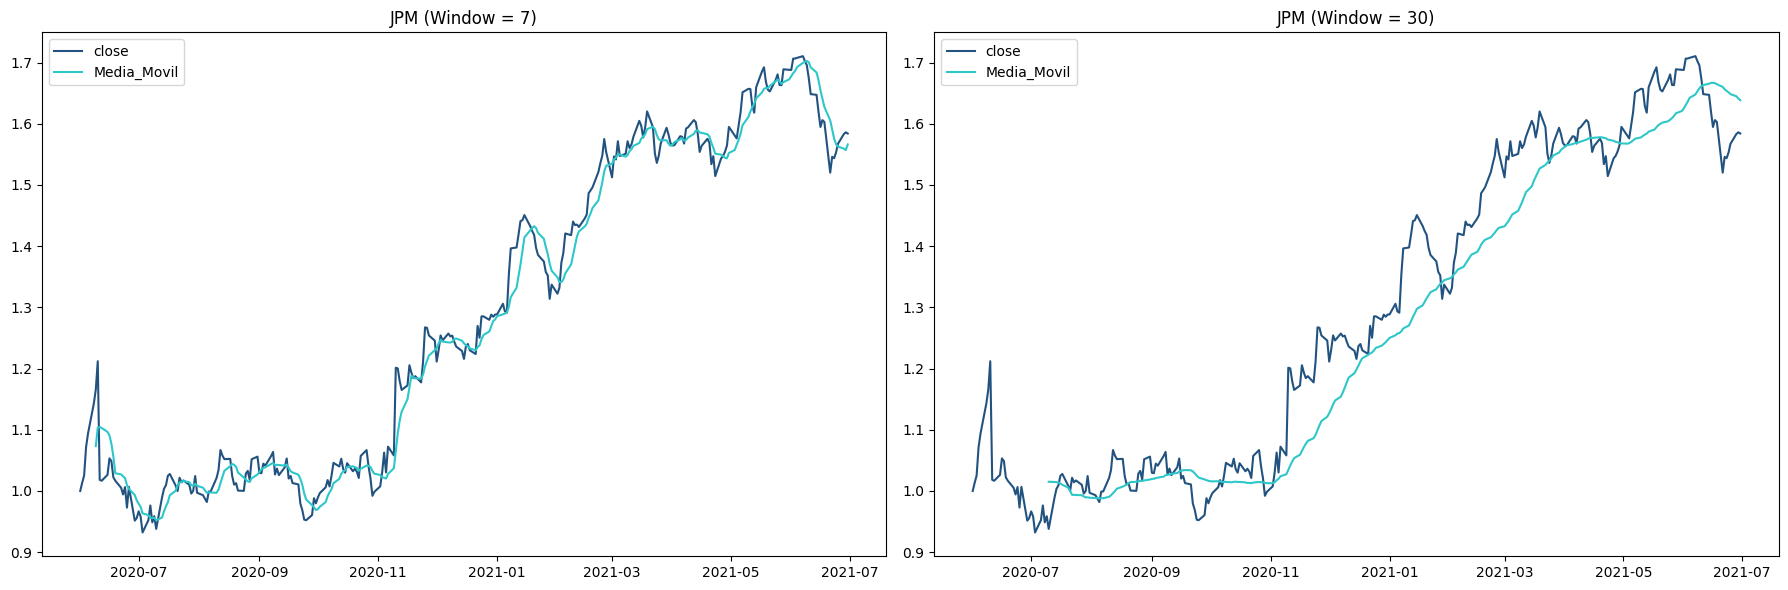

In [9]:
def grafico_con_media_movil(dataframe, window1, window2, title):
    df_suave1 = dataframe.copy()
    df_suave1['Media_Movil'] = dataframe["close"].rolling(window=window1).mean()
    
    df_suave2 = dataframe.copy()
    df_suave2['Media_Movil'] = dataframe["close"].rolling(window=window2).mean()

    # Define los colores para close y Media_Movil
    colors = ['#225380', '#2DC7C9']

    # Crea los dos gráficos
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    df_suave1[['close', 'Media_Movil']].plot(ax=axs[0], color=colors)
    df_suave2[['close', 'Media_Movil']].plot(ax=axs[1], color=colors)

    axs[0].set_title(f'{title} (Window = {window1})')
    axs[1].set_title(f'{title} (Window = {window2})')

    # Guarda la imagen combinada en la carpeta "imagenes" con el nombre especificado
    plt.tight_layout()

# Llamada para generar el gráfico combinado (con dos visualizaciones)
grafico_con_media_movil(df1, window1=7, window2=30, title='JPM')


* Lowess

In [10]:
def carga_datos_seleccionados_1():
    df_1 = pd.read_csv('Datos/Transformados/diarios/JPM_marketstack.csv', index_col='date')
    df_2 = pd.read_csv('Datos/Transformados/diarios/CAT_marketstack.csv',index_col='date')
    df_3 = pd.read_csv('Datos/Transformados/diarios/GS_marketstack.csv',index_col='date')
    return df_1, df_2, df_3

df_1, df_2, df_3 = carga_datos_seleccionados_1()

for df in [df_1, df_2, df_3]:
    df.rename(columns={'close_cubic':'close'}, inplace=True)

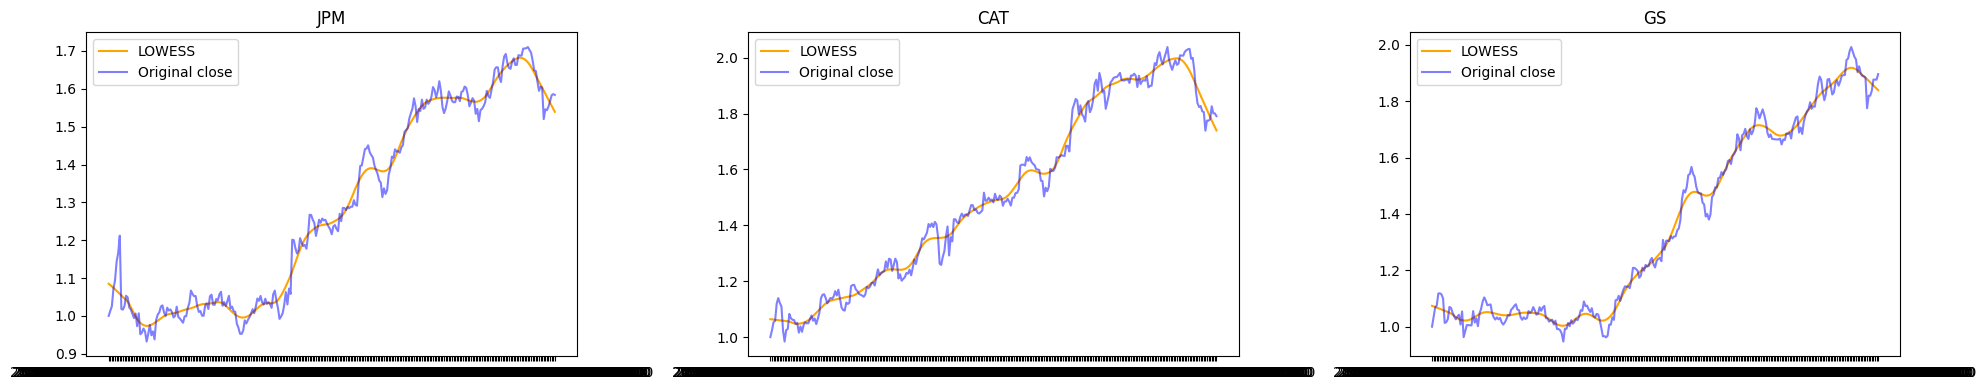

In [11]:
def evolucion_lowess(df1, df2, df3):
    #utilización de lowess
    df1, df2, df3 = normalizar(df1, df2, df3)
    fig, axs = plt.subplots(1, 3, figsize=(20, 4))

    for i, (df, title) in enumerate([(df1, 'JPM'), (df2, 'CAT'), (df3, 'GS')]):
        axs[i].set_title(title)
        df_suave = df.copy()
        lowess_results = sm.nonparametric.lowess(df_suave['close'], range(len(df_suave['close'])), frac=0.1, it=0)
        axs[i].plot(lowess_results[:, 0], lowess_results[:, 1], label='LOWESS', color='orange')
        axs[i].plot(df_suave['close'], label='Original close', color='blue', alpha=0.5)
        axs[i].legend()

    plt.tight_layout()
    plt.show()

evolucion_lowess(df_1, df_2, df_3)

### Tendencia

* Diferenciación de la serie

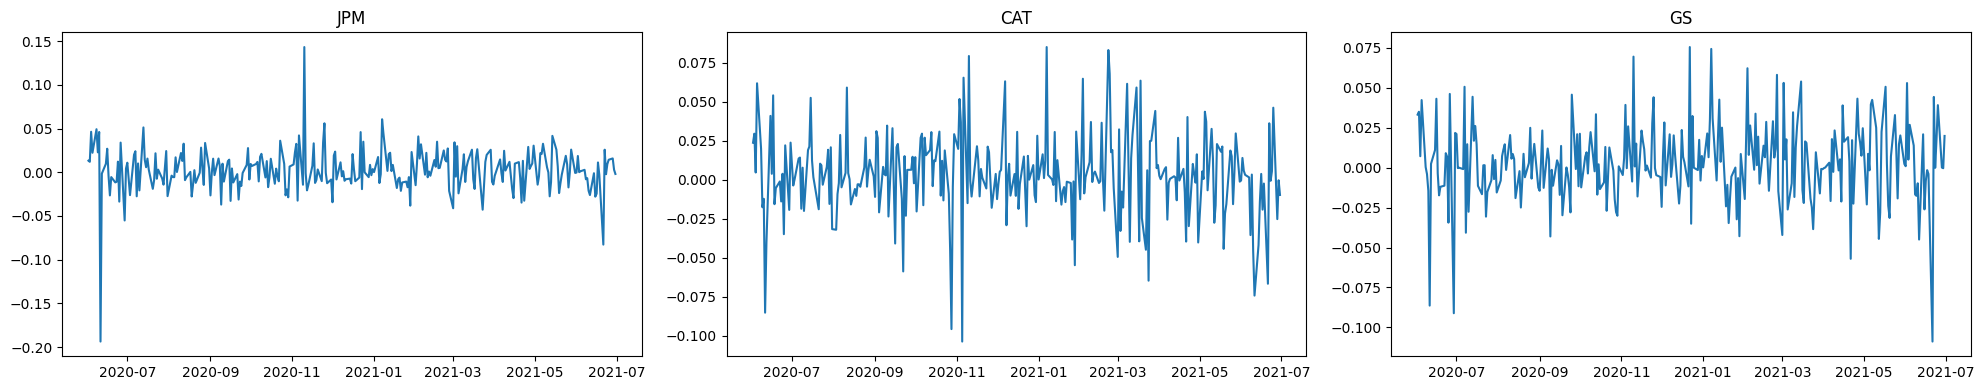

In [12]:
def close_diff(dataframes_titulos):
    num_plots = len(dataframes_titulos)
    fig, axs = plt.subplots(1, num_plots, figsize=(20, 4))

    for i, (df, title) in enumerate(dataframes_titulos):
        axs[i].set_title(title)
        df_trend = df.copy()
        df_trend['Close_diff'] = df_trend['close'].diff()
        df_trend['Close_diff'].plot(ax=axs[i])

    plt.tight_layout()
    plt.show()

# Crear una lista de DataFrames y títulos
dataframes_titulos = [(df1, 'JPM'), (df2, 'CAT'), (df3, 'GS')]

close_diff(dataframes_titulos)


* Eliminación de media móvil

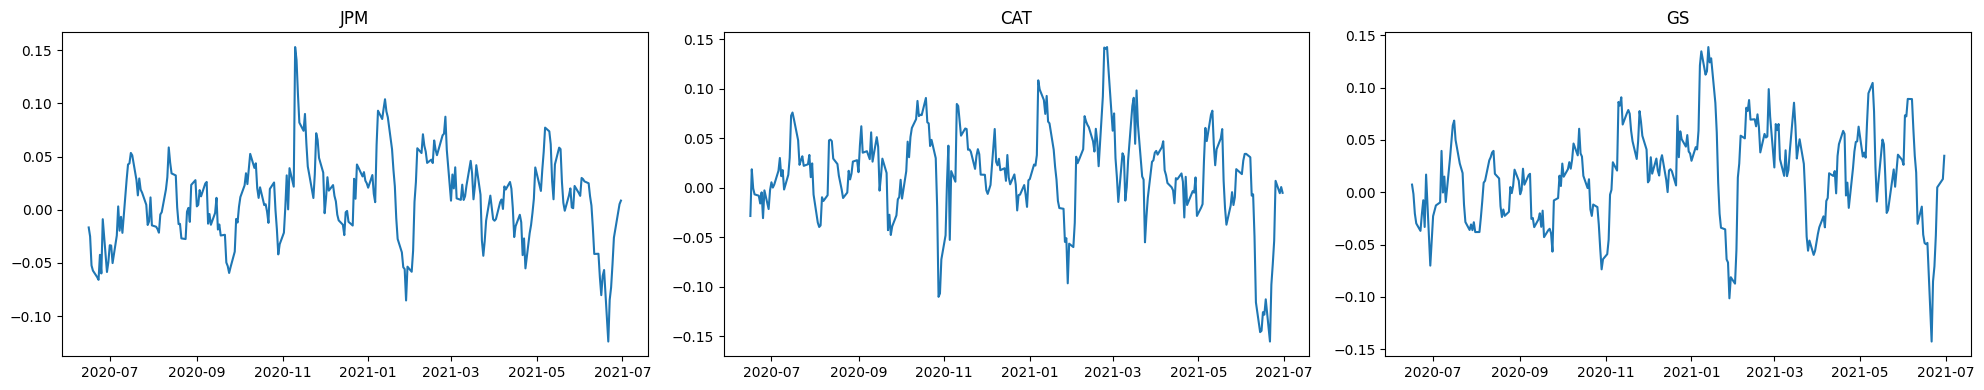

In [13]:
def rolling_mean_difference(dataframes_titulos):
    num_plots = len(dataframes_titulos)
    fig, axs = plt.subplots(1, num_plots, figsize=(20, 4))

    for i, (df, title) in enumerate(dataframes_titulos):
        axs[i].set_title(title)
        df_trend = df.copy()
        df_trend['Media_movil'] = df_trend['close'] - df_trend['close'].rolling(window=12).mean()
        df_trend['Media_movil'].plot(ax=axs[i])

    plt.tight_layout()
    plt.show()

# Crear una lista de DataFrames y títulos
dataframes_titulos = [(df1, 'JPM'), (df2, 'CAT'), (df3, 'GS')]

rolling_mean_difference(dataframes_titulos)


* Seasonal decompose

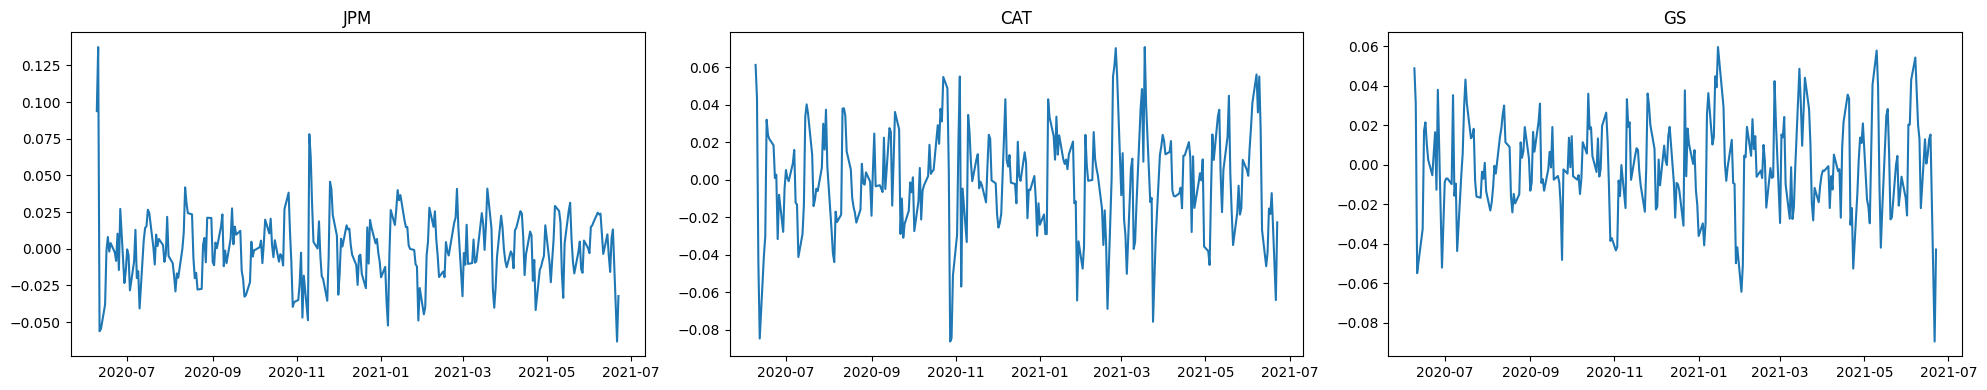

In [14]:
def seasonal_decompose_plot(dataframes_titulos):
    num_plots = len(dataframes_titulos)
    fig, axs = plt.subplots(1, num_plots, figsize=(20, 4))

    for i, (df, title) in enumerate(dataframes_titulos):
        axs[i].set_title(title)
        df_trend = df.copy()
        df_trend.index = pd.to_datetime(df_trend.index)
        result = seasonal_decompose(df_trend, model='additive', period=12)
        trend = result.trend
        df_trend['seas_dec'] = df_trend.close.values - trend

        axs[i].plot(df_trend['seas_dec'], label='Seasonal Decompose')

    plt.tight_layout()
    plt.show()

# Crear una lista de DataFrames y títulos
dataframes_titulos = [(df1, 'JPM'), (df2, 'CAT'), (df3, 'GS')]

seasonal_decompose_plot(dataframes_titulos)


* Hodrick Prescott Detrending

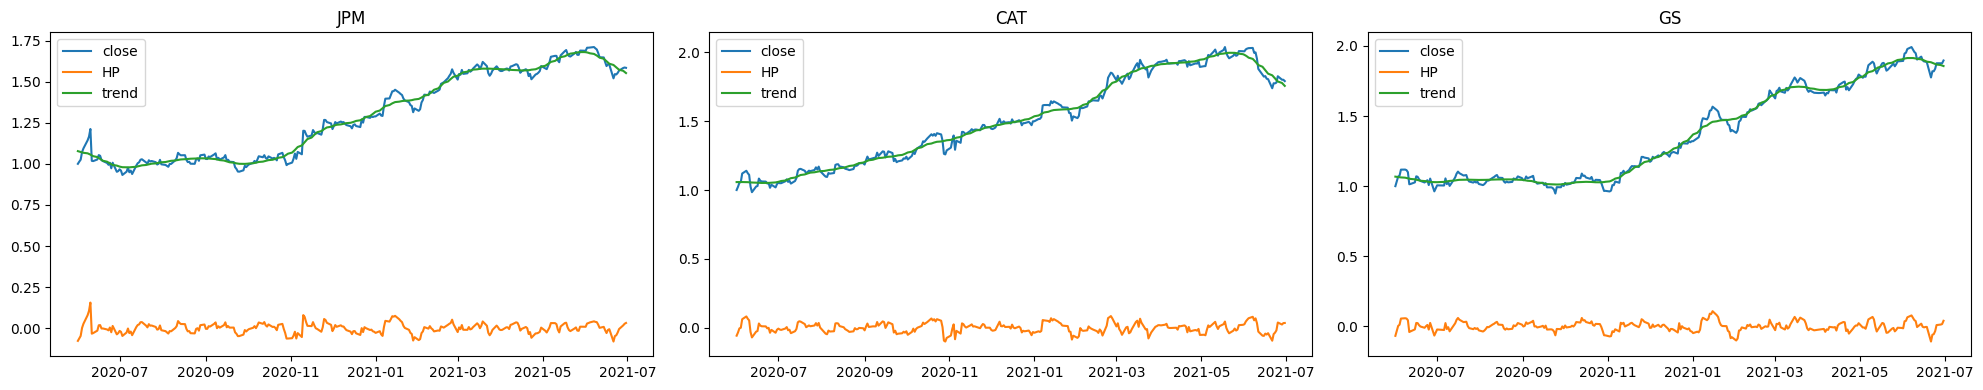

In [15]:
def hodrick_prescott_detrend(dataframes_titulos):
    num_plots = len(dataframes_titulos)
    fig, axs = plt.subplots(1, num_plots, figsize=(20, 4))

    for i, (df, title) in enumerate(dataframes_titulos):
        axs[i].set_title(title)
        df_trend = df.copy()
        df_trend["HP"], df_trend["trend"] = sm.tsa.filters.hpfilter(df_trend[['close']])
        df_trend[['close', 'HP', "trend"]].plot(ax=axs[i])

    plt.tight_layout()
    plt.show()

# Crear una lista de DataFrames y títulos
dataframes_titulos = [(df1, 'JPM'), (df2, 'CAT'), (df3, 'GS')]

# Llamar a la función con la lista de DataFrames y títulos
hodrick_prescott_detrend(dataframes_titulos)


* Baxter-King filtered

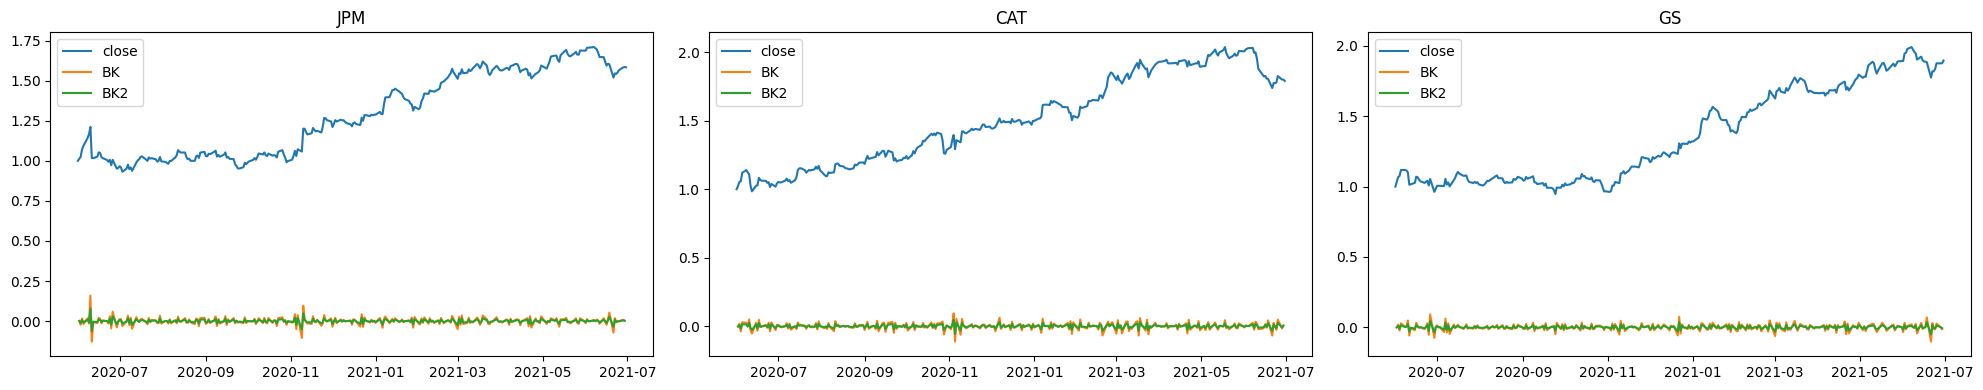

In [16]:
def baxter_king_filter(dataframes_titulos):
    num_plots = len(dataframes_titulos)
    fig, axs = plt.subplots(1, num_plots, figsize=(20, 4))

    for i, (df, title) in enumerate(dataframes_titulos):
        axs[i].set_title(title)  # Establece el título con el nombre del DataFrame
        df_trend = df.copy()
        df_trend["BK"] = sm.tsa.filters.bkfilter(df_trend[['close']], 1, 12, 1)
        df_trend["BK2"] = sm.tsa.filters.bkfilter(df_trend[['close']], 1, 2, 1)
        df_trend[['close', 'BK', "BK2"]].plot(ax=axs[i])

    plt.tight_layout()
    plt.show()

# Crear una lista de DataFrames y títulos
dataframes_titulos = [(df1, 'JPM'), (df2, 'CAT'), (df3, 'GS')]

# Llamar a la función con la lista de DataFrames y títulos
baxter_king_filter(dataframes_titulos)


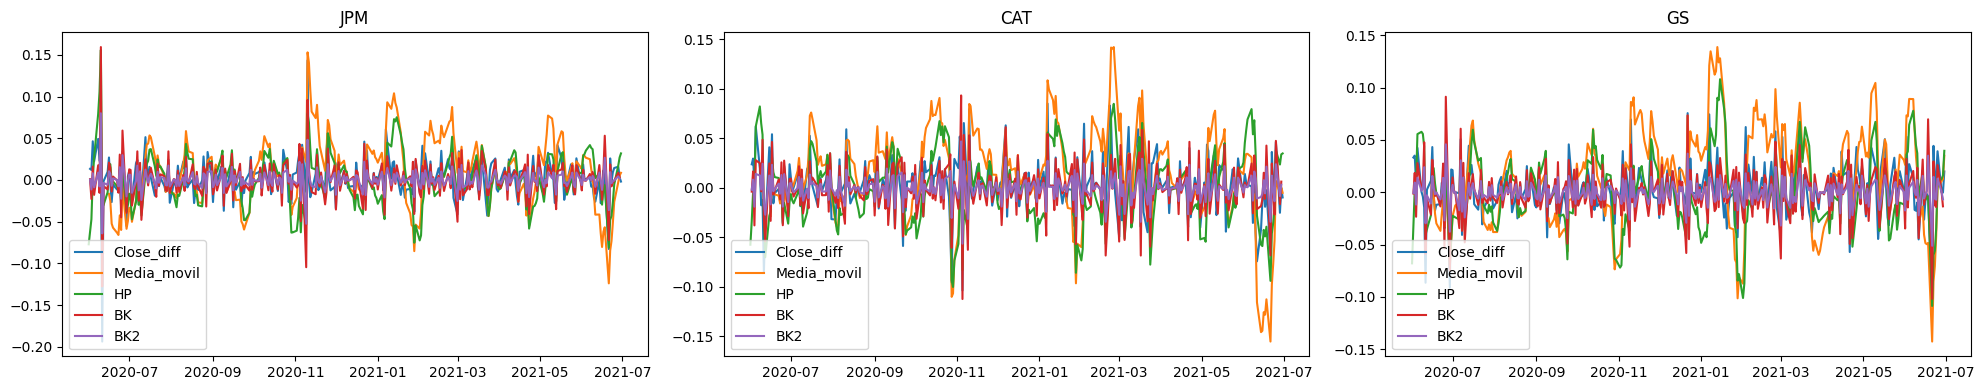

In [17]:
def general(dataframes_titulos):
    num_plots = len(dataframes_titulos)
    fig, axs = plt.subplots(1, num_plots, figsize=(20, 4))

    for i, (df, title) in enumerate(dataframes_titulos):
        axs[i].set_title(title)
        df_trend = df.copy()
        df_trend['Close_diff'] = df_trend['close'].diff()
        df_trend['Media_movil'] = df_trend['close'] - df_trend['close'].rolling(window=12).mean()
        df_trend["HP"], df_trend["trend"] = sm.tsa.filters.hpfilter(df_trend[['close']])
        df_trend["BK"] = sm.tsa.filters.bkfilter(df_trend[['close']], 1, 12, 1)
        df_trend["BK2"] = sm.tsa.filters.bkfilter(df_trend[['close']], 1, 2, 1)
        df_trend[['Close_diff','Media_movil','HP','BK', "BK2"]].plot(ax=axs[i])

    plt.tight_layout()
    plt.show()

# Crear una lista de DataFrames y títulos
dataframes_titulos = [(df1, 'JPM'), (df2, 'CAT'), (df3, 'GS')]

# Llamar a la función con la lista de DataFrames y títulos
general(dataframes_titulos)


### Estacionalidad

* Autocorrelación

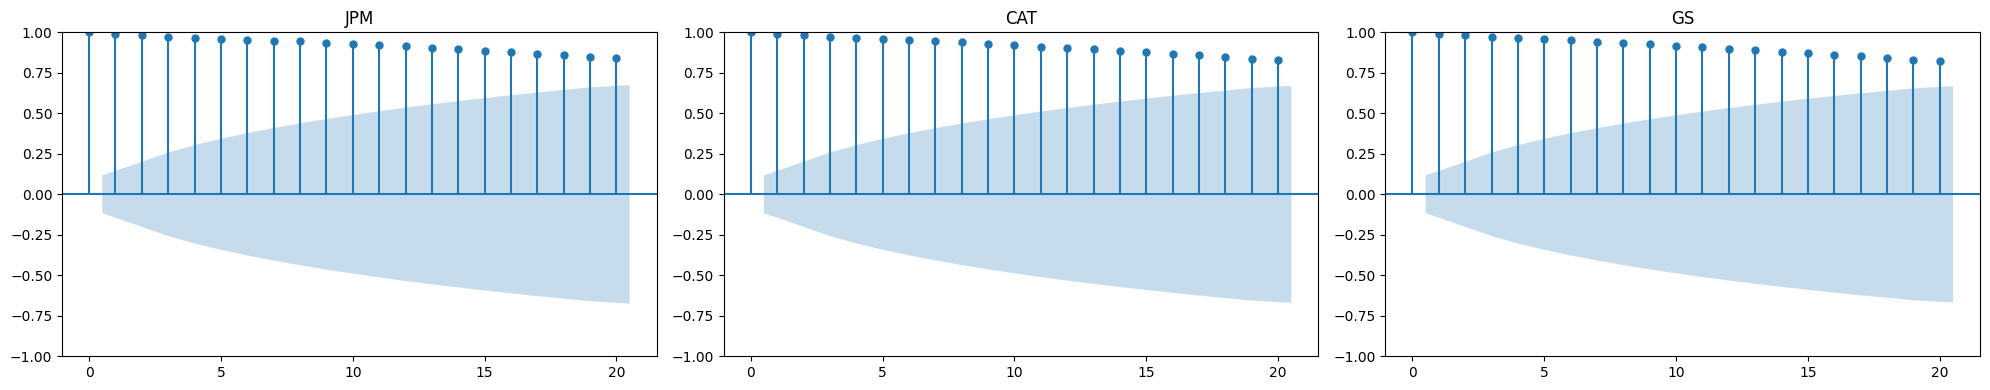

In [18]:
def autocorrelaciones(df1,df2,df3):
    fig, axs = plt.subplots(1, 3, figsize=(20, 4))

    for i, (df, title) in enumerate([(df1, 'JPM'), (df2, 'CAT'), (df3, 'GS')]):
        axs[i].set_title(title)
        tsaplots.plot_acf(df['close'], lags=20, ax=axs[i], title=title)

    plt.tight_layout()
    plt.show()

autocorrelaciones(df1,df2,df3)

c:\Users\uxueu\.conda\envs\reto9_bbva\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


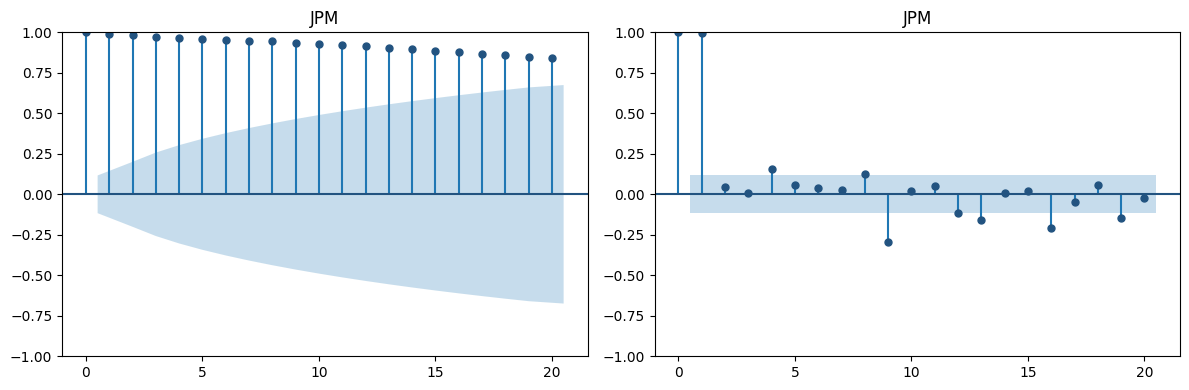

In [19]:
#grafico de acf y pacf para jpm y de color rojo
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
tsaplots.plot_acf(df1['close'], lags=20, ax=axs[0], title='JPM', color= '#225380')
tsaplots.plot_pacf(df1['close'], lags=20, ax=axs[1], title='JPM', color= '#225380')
plt.tight_layout()
plt.show()

* Media temporal

In [20]:
def carga_datos_seleccionados_media_temporal():
    df11 = pd.read_csv('Datos/Transformados/diarios/JPM_marketstack.csv', index_col='date')
    df22 = pd.read_csv('Datos/Transformados/diarios/CAT_marketstack.csv',index_col='date')
    df33 = pd.read_csv('Datos/Transformados/diarios/GS_marketstack.csv',index_col='date')
    df11.index = pd.to_datetime(df11.index, format='%Y-%m-%d')
    df22.index = pd.to_datetime(df22.index, format='%Y-%m-%d')
    df33.index = pd.to_datetime(df33.index, format='%Y-%m-%d')
    return df11, df22, df33

df11, df22, df33 = carga_datos_seleccionados_media_temporal()
for df in [df11, df22, df33]:
    df.rename(columns={'close_cubic':'close'}, inplace=True)

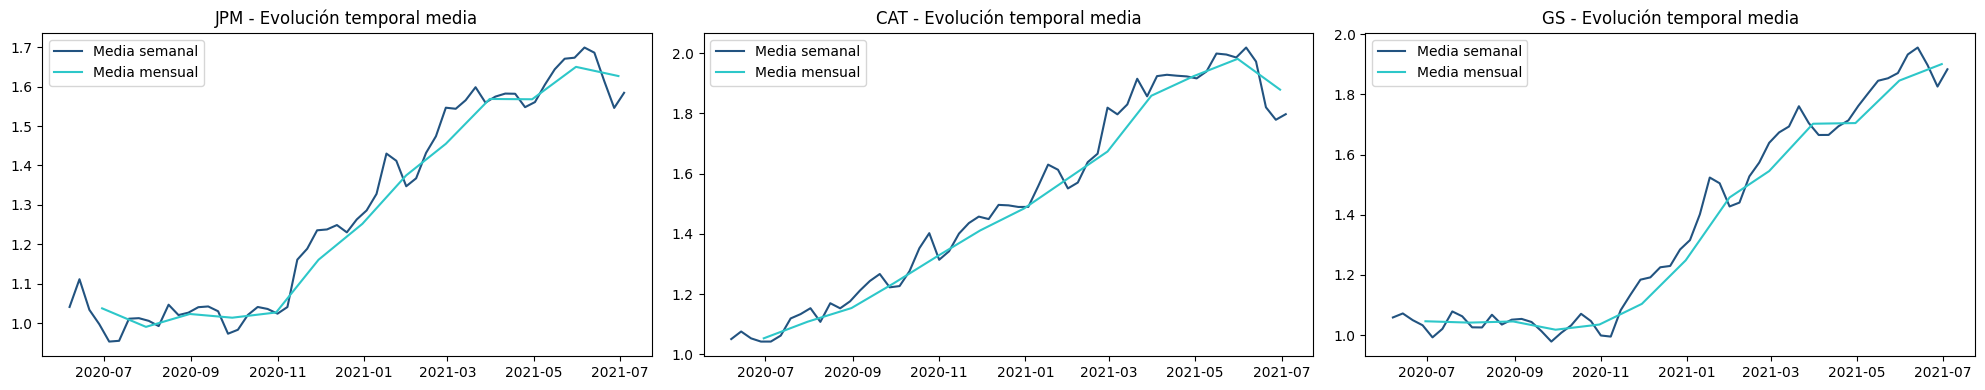

In [21]:
def media_temporal(df1, df2, df3):
    df1, df2, df3 = normalizar(df1, df2, df3)
    fig, axs = plt.subplots(1, 3, figsize=(20, 4))
    dfs = [df1, df2, df3]
    titles = ['JPM', 'CAT', 'GS']
    
    for i in range(3):
        df = dfs[i]
        axs[i].set_title(f'{titles[i]} - Evolución temporal media')
        
        weekly_mean = df.resample('W').mean()
        monthly_mean = df.resample('M').mean()
        
        axs[i].plot(weekly_mean.index, weekly_mean['close'], label='Media semanal', color = '#225380')
        axs[i].plot(monthly_mean.index, monthly_mean['close'], label='Media mensual', color = '#2DC7C9')
        axs[i].legend()
    
    plt.tight_layout()
    plt.show()

media_temporal(df11, df22, df33)

* Seasonal Decompose

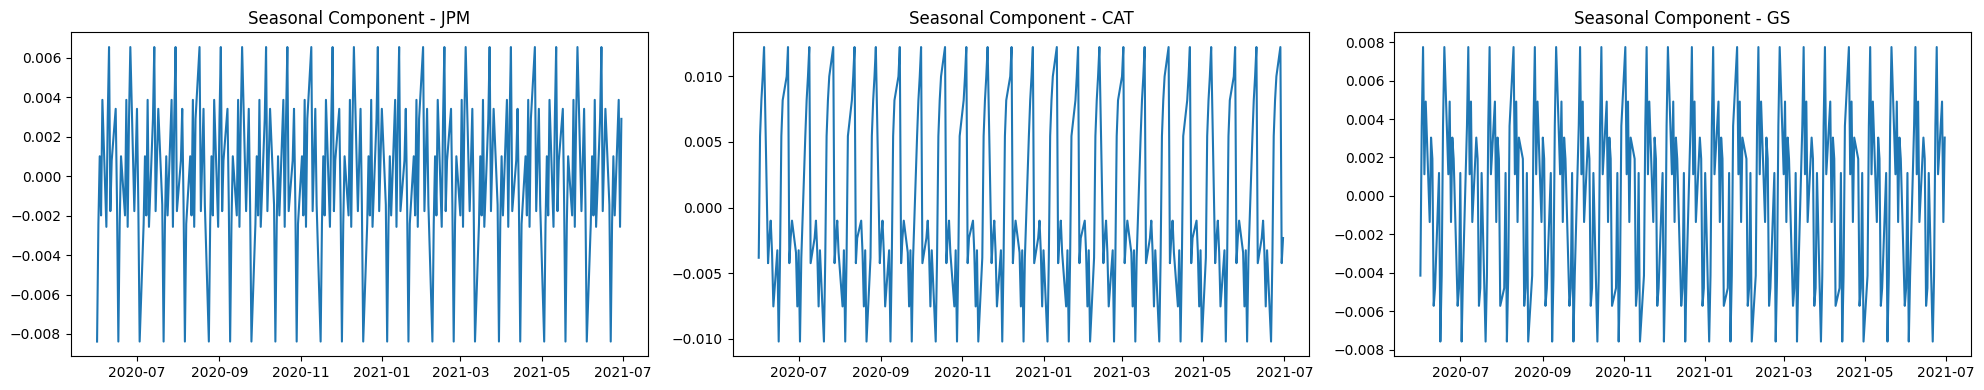

In [22]:
def seasonal_decomposition(df1, df2, df3):
    fig, axs = plt.subplots(1, 3, figsize=(20, 4))
    dfs = [df1, df2, df3]
    titles = ['JPM', 'CAT', 'GS']

    for i, (df, title) in enumerate(zip(dfs, titles)):
        axs[i].set_title(f'Seasonal Component - {title}')
        result = seasonal_decompose(df, model='additive', period=12)
        result.seasonal.plot(ax=axs[i])
        
    plt.tight_layout()
    plt.show()

seasonal_decomposition(df1, df2, df3)

### Estacionariedad

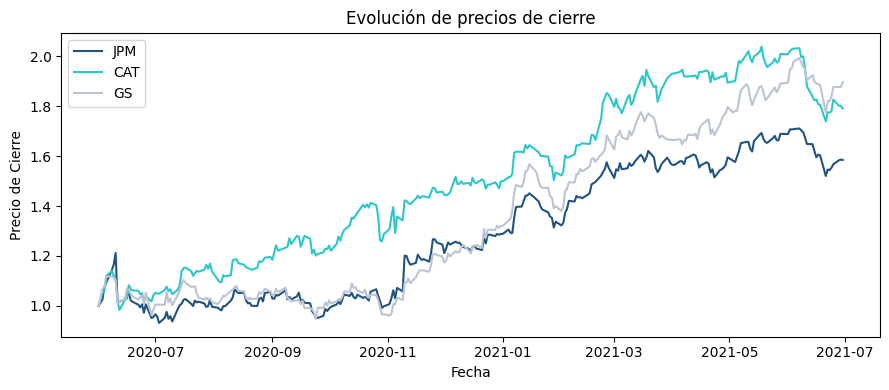

In [23]:
evolucion_close(df1, df2, df3)

In [24]:
# ADF test
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')
    print(f'Result: The series is {"not " if result[1] > 0.05 else ""}stationary')

In [25]:
# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

In [26]:
#eliminar la tendencia diferencia y guardarlo en df1, df2, df3
for df in [df1, df2, df3]:
    df['close_diff'] = df['close'].diff()
    df.dropna(inplace=True)

La serie original presenta tendencia por lo que no es estacionaria

In [27]:
def adf_test_seleccionados(df1, df2, df3):
    for df in [df1, df2, df3]:
        adf_test(df['close_diff'])
        print('\n')

adf_test_seleccionados(df1, df2, df3)

ADF Statistic: -17.602240450567923
p-value: 3.9162141011007576e-30
Critial Values:
   1%, -3.4538376962008495
Critial Values:
   5%, -2.8718811911083093
Critial Values:
   10%, -2.5722803076202174
Result: The series is stationary


ADF Statistic: -17.118441318654572
p-value: 7.284363939230629e-30
Critial Values:
   1%, -3.4538376962008495
Critial Values:
   5%, -2.8718811911083093
Critial Values:
   10%, -2.5722803076202174
Result: The series is stationary


ADF Statistic: -11.043663340819707
p-value: 5.2886742332317487e-20
Critial Values:
   1%, -3.453922368485787
Critial Values:
   5%, -2.871918329081633
Critial Values:
   10%, -2.5723001147959184
Result: The series is stationary




In [28]:
def kpss_test_seleccionados(df1, df2, df3):
    for df in [df1, df2, df3]:
        kpss_test(df['close_diff'])
        print('\n')

kpss_test_seleccionados(df1, df2, df3)

KPSS Statistic: 0.08503675866576135
p-value: 0.1
num lags: 7
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


KPSS Statistic: 0.12957772725219288
p-value: 0.1
num lags: 1
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


KPSS Statistic: 0.14004291214065046
p-value: 0.1
num lags: 2
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary




c:\Users\uxueu\.conda\envs\reto9_bbva\lib\site-packages\statsmodels\tsa\stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
c:\Users\uxueu\.conda\envs\reto9_bbva\lib\site-packages\statsmodels\tsa\stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
c:\Users\uxueu\.conda\envs\reto9_bbva\lib\site-packages\statsmodels\tsa\stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


### Previsibilidad

Entropía aproximada

In [29]:
def ApEn(U, m, r):
    """Compute Aproximate entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    N = len(U)
    return abs(_phi(m+1) - _phi(m))

Entropía de muestreo

In [30]:
def SampEn(U, m, r):
    """Compute Sample entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))

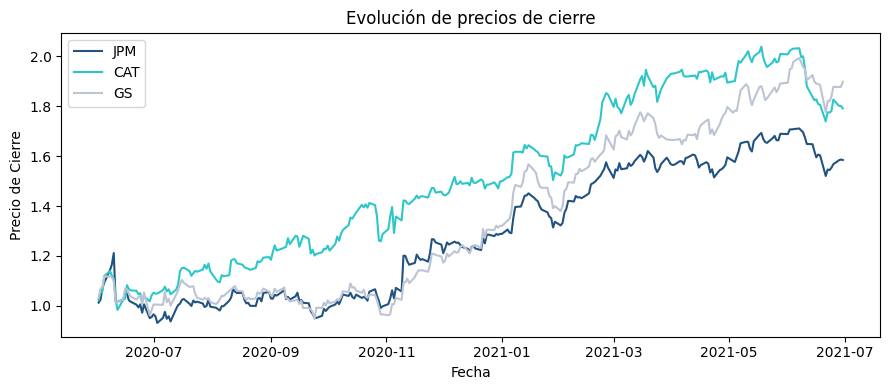

In [31]:
evolucion_close(df1, df2, df3)

In [32]:
def entropias(df1, df2, df3):
    for df in [df1, df2, df3]:
        print("Aproximate entropy",ApEn(df.close, m=2, r=0.2*np.std(df.close)))
        print("Sample entropy",SampEn(df.close, m=2, r=0.2*np.std(df.close)))
        print("")

entropias(df1,df2,df3)

Aproximate entropy 0.22863102300299643


Sample entropy 0.17897696654335815

Aproximate entropy 0.2342311225391831
Sample entropy 0.19300740917380027

Aproximate entropy 0.17340386732231394
Sample entropy 0.12921672537496964



### Volatilidad

Se toman los datos de cierre de los índices y se calcula el rendimiento en cada instante temporal:

$Rendimiento(t) = \frac{Cierre(t)-Cierre(t-1)}{Cierre(t-1)}*100$

In [33]:
df1, df2, df3 = carga_datos_seleccionados()
for df in [df1, df2, df3]:
    df.rename(columns={'close_cubic':'close'}, inplace=True)

In [34]:
df1.head()

close
2020-06-01   97.310000
2020-06-02   98.600000
2020-06-03   99.762098
2020-06-04  104.270000
2020-06-05  106.440000

In [35]:
def calculo_ren_vol(df1,df2,df3):
    df_vol1 = df1.copy()
    df_vol2 = df2.copy()
    df_vol3 = df3.copy()
    for df in [df_vol1, df_vol2, df_vol3]:
        df['close_ret'] = df['close'].pct_change()
        df["close_vol"] = df.close_ret.mul(df.close_ret)
    return df_vol1, df_vol2, df_vol3

df_vol1, df_vol2, df_vol3 = calculo_ren_vol(df1,df2,df3)

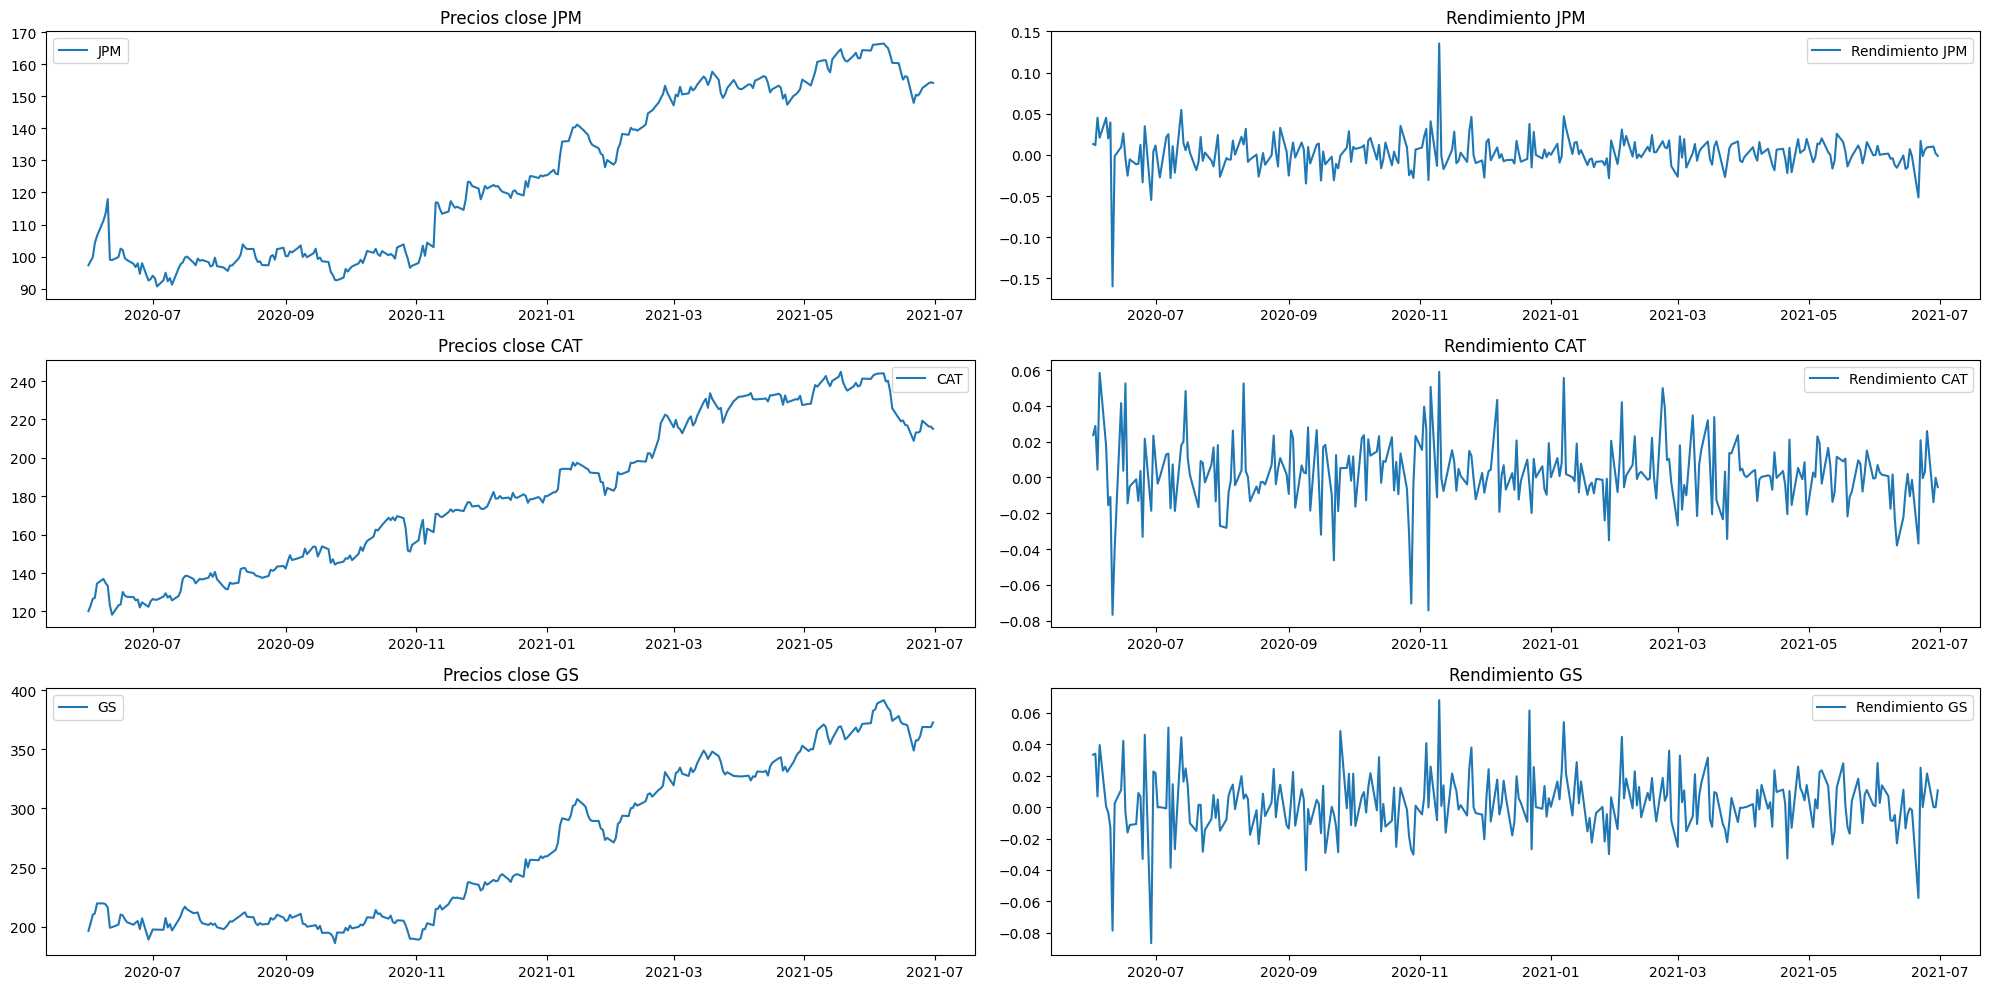

In [36]:
def precios_ren(df1, df2, df3):
    plt.rcParams["figure.figsize"] = (20, 10)
    
    fig, ax = plt.subplots(3, 2)

    # Gráficos para el primer DataFrame (df1)
    ax[0, 0].plot(df1.close, label="JPM")
    ax[0, 0].set_title("Precios close JPM")
    ax[0, 0].legend()

    ax[0, 1].plot(df1.close_ret, label="Rendimiento JPM")
    ax[0, 1].set_title("Rendimiento JPM")
    ax[0, 1].legend()

    # Gráficos para el segundo DataFrame (df2)
    ax[1, 0].plot(df2.close, label="CAT")
    ax[1, 0].set_title("Precios close CAT")
    ax[1, 0].legend()

    ax[1, 1].plot(df2.close_ret, label="Rendimiento CAT")
    ax[1, 1].set_title("Rendimiento CAT")
    ax[1, 1].legend()

    # Gráficos para el tercer DataFrame (df3)
    ax[2, 0].plot(df3.close, label="GS")
    ax[2, 0].set_title("Precios close GS")
    ax[2, 0].legend()

    ax[2, 1].plot(df3.close_ret, label="Rendimiento GS")
    ax[2, 1].set_title("Rendimiento GS")
    ax[2, 1].legend()

    plt.tight_layout()
    plt.show()

precios_ren(df_vol1, df_vol2, df_vol3)


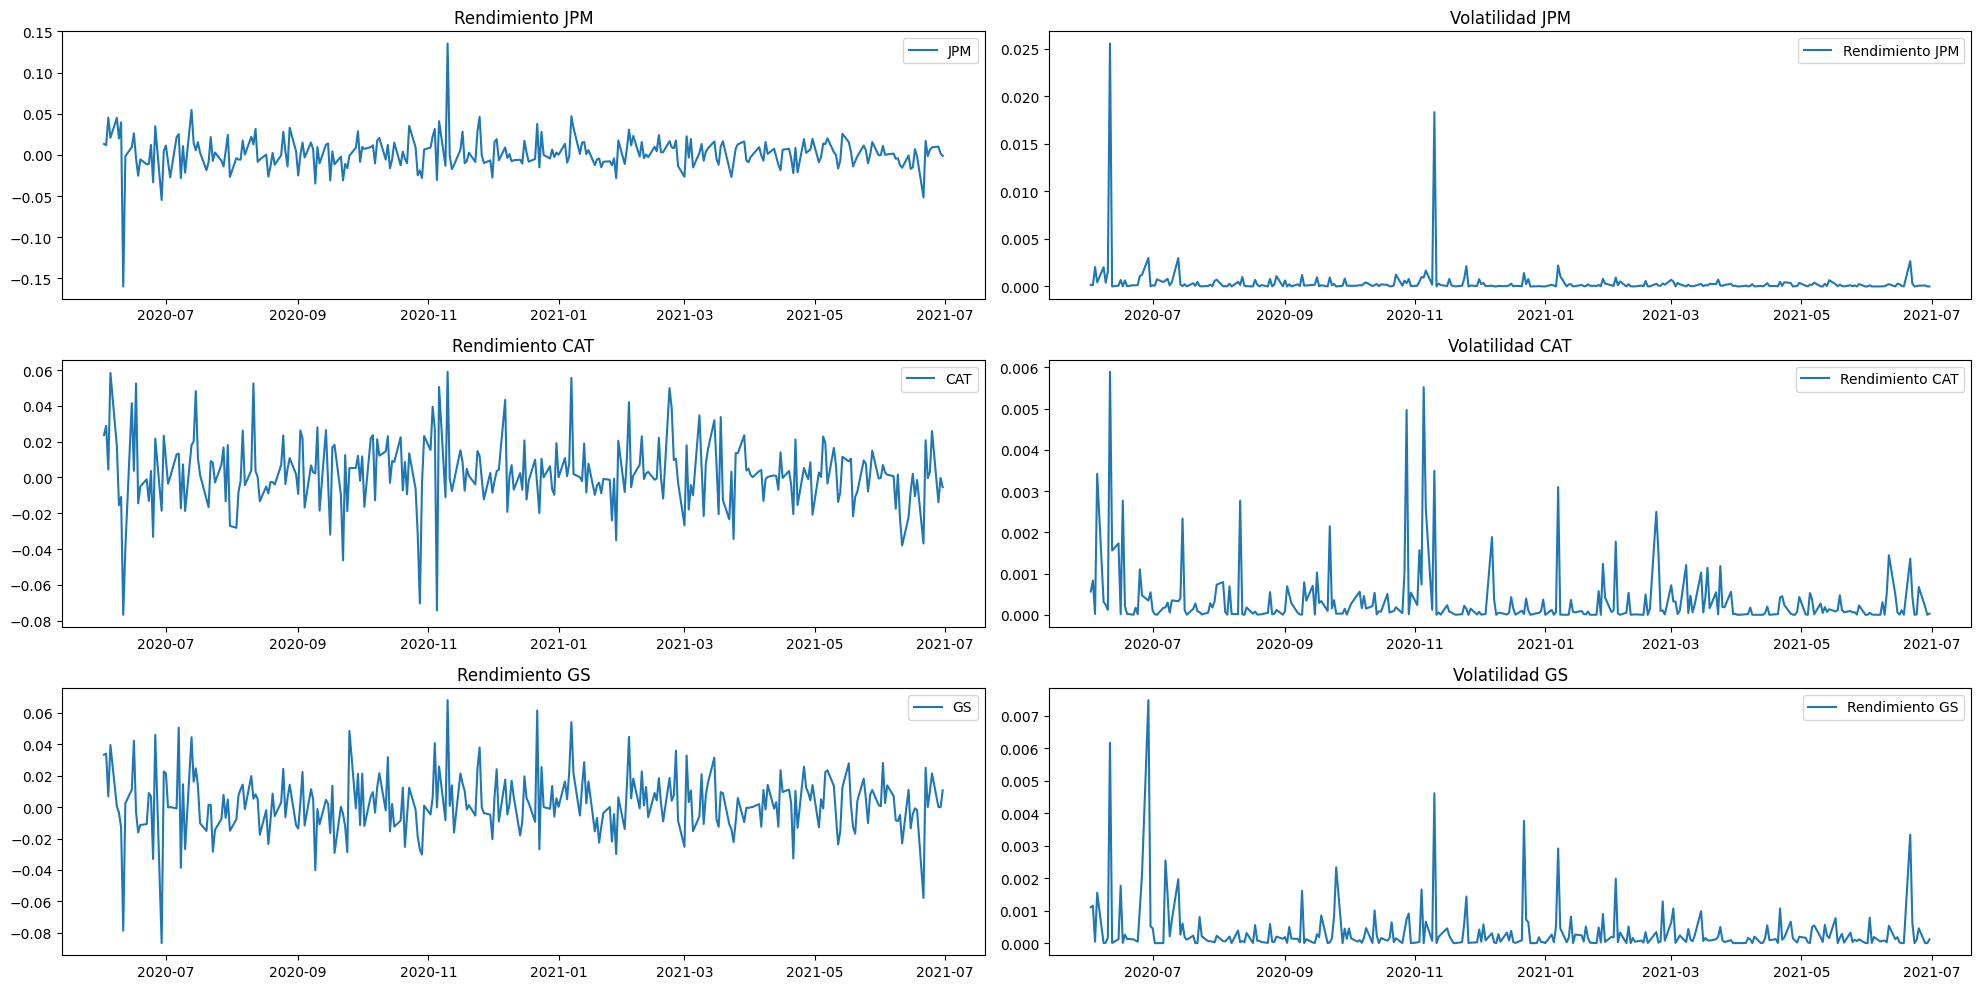

In [37]:
def ren_vol(df1, df2, df3):
    plt.rcParams["figure.figsize"] = (20, 10)
    
    fig, ax = plt.subplots(3, 2)

    # Gráficos para el primer DataFrame (df1)
    ax[0, 0].plot(df1.close_ret, label="JPM")
    ax[0, 0].set_title("Rendimiento JPM")
    ax[0, 0].legend()

    ax[0, 1].plot(df1.close_vol, label="Rendimiento JPM")
    ax[0, 1].set_title("Volatilidad JPM")
    ax[0, 1].legend()

    # Gráficos para el segundo DataFrame (df2)
    ax[1, 0].plot(df2.close_ret, label="CAT")
    ax[1, 0].set_title("Rendimiento CAT")
    ax[1, 0].legend()

    ax[1, 1].plot(df2.close_vol, label="Rendimiento CAT")
    ax[1, 1].set_title("Volatilidad CAT")
    ax[1, 1].legend()

    # Gráficos para el tercer DataFrame (df3)
    ax[2, 0].plot(df3.close_ret, label="GS")
    ax[2, 0].set_title("Rendimiento GS")
    ax[2, 0].legend()

    ax[2, 1].plot(df3.close_vol, label="Rendimiento GS")
    ax[2, 1].set_title("Volatilidad GS")
    ax[2, 1].legend()

    plt.tight_layout()
    plt.show()

ren_vol(df_vol1, df_vol2, df_vol3)

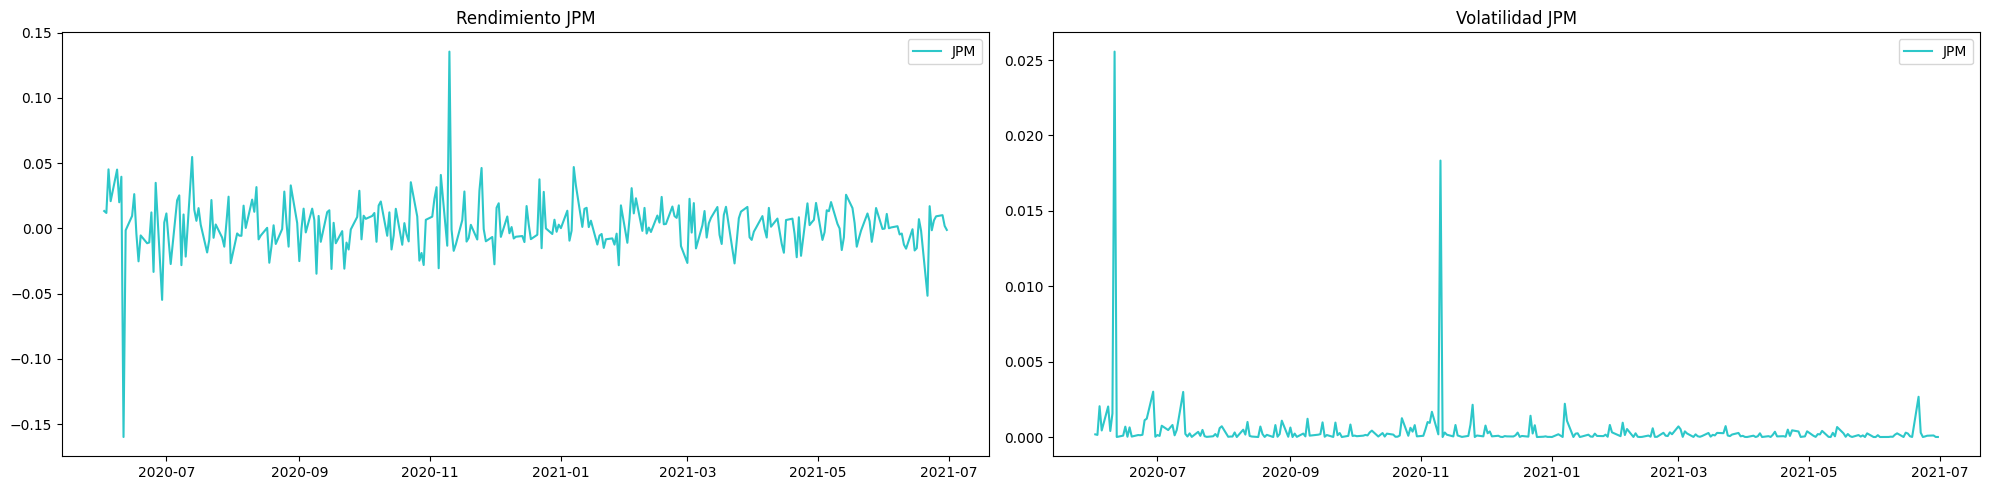

In [38]:
plt.rcParams["figure.figsize"] = (20, 5)

fig, ax = plt.subplots(1, 2)

ax[0].plot(df_vol1.close_ret, label="JPM", color = '#2DC7C9')
ax[0].set_title(f"Rendimiento JPM")
ax[0].legend()

ax[1].plot(df_vol1.close_vol, label="JPM", color = '#2DC7C9')
ax[1].set_title(f"Volatilidad JPM")
ax[1].legend()

plt.tight_layout()
plt.show()

Descomposición de la serie original

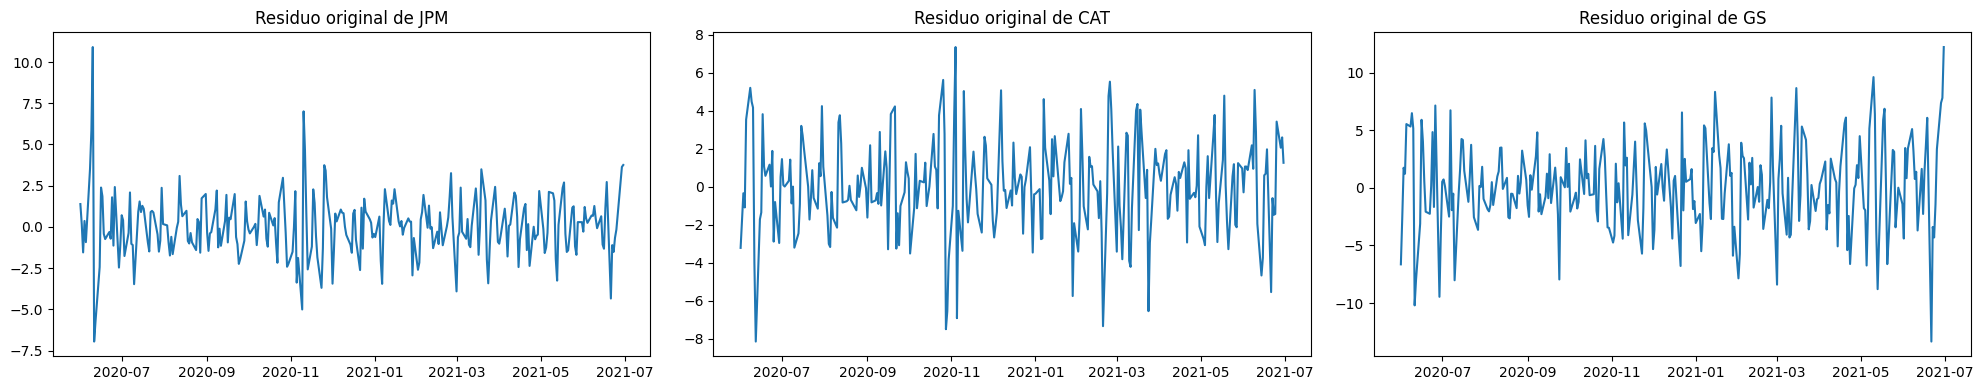

In [39]:
def descomposicion_original(df1, df2, df3):
    plt.rcParams["figure.figsize"] = (20, 4)
    fig, ax = plt.subplots(1, 3)
        
    dataframes = [df1, df2, df3]
    lista = ["JPM", "CAT", "GS"]

    for i, df in enumerate(dataframes):
        result = seasonal_decompose(df.close, model='additive', period=7, extrapolate_trend=1)
        df["residuo"] = result.resid
        ax[i].plot(df["residuo"])
        ax[i].set_title(f"Residuo original de {lista[i]}")

    plt.tight_layout()
    plt.show()

descomposicion_original(df_vol1, df_vol2, df_vol3)

Train - Test split

In [40]:
#pasar el índice a columna date y generar un nuevo índice
df_vol1.reset_index(inplace=True)
df_vol2.reset_index(inplace=True)
df_vol3.reset_index(inplace=True)

#transformar nombre de la columna index a date
df_vol1.rename(columns={'index':'date'}, inplace=True)
df_vol2.rename(columns={'index':'date'}, inplace=True)
df_vol3.rename(columns={'index':'date'}, inplace=True)

In [41]:
df_vol1.head()

date       close  close_ret  close_vol   residuo
0  2020-06-01   97.310000        NaN        NaN  1.388352
1  2020-06-02   98.600000   0.013257   0.000176  0.168452
2  2020-06-03   99.762098   0.011786   0.000139 -1.543094
3  2020-06-04  104.270000   0.045187   0.002042  0.363602
4  2020-06-05  106.440000   0.020811   0.000433 -0.920362

In [42]:
def train_test(df):
    fecha_1 = datetime.strptime("2021-05-31", "%Y-%m-%d").date()
    fecha_2 = datetime.strptime("2021-06-01", "%Y-%m-%d").date()
    train = df[df['date'] <= fecha_1]
    test = df[df['date'] >= fecha_2]
    return train, test

train_df1, test_df1 = train_test(df_vol1)
train_df2, test_df2 = train_test(df_vol2)
train_df3, test_df3 = train_test(df_vol3)

Gráficos PACF

In [43]:
def graficos_acf_pacf(df, titulo):
    plt.rcParams["figure.figsize"] = (20, 7)

    fig, ax = plt.subplots(2, 2)

    sgt.plot_acf(df.close, ax=ax[0, 0], auto_ylims=True, title="ACF de la serie")
    sgt.plot_pacf(df.close, ax=ax[0, 1], auto_ylims=True, title="PACF de la serie")

    residuo2 = df["residuo"].mul(df["residuo"])

    sgt.plot_acf(residuo2, ax=ax[1, 0], auto_ylims=True, title="ACF del residuo al cuadrado")
    sgt.plot_pacf(residuo2, ax=ax[1, 1], auto_ylims=True, title="PACF del residuo al cuadrado")

    plt.suptitle(titulo, size=20)


c:\Users\uxueu\.conda\envs\reto9_bbva\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


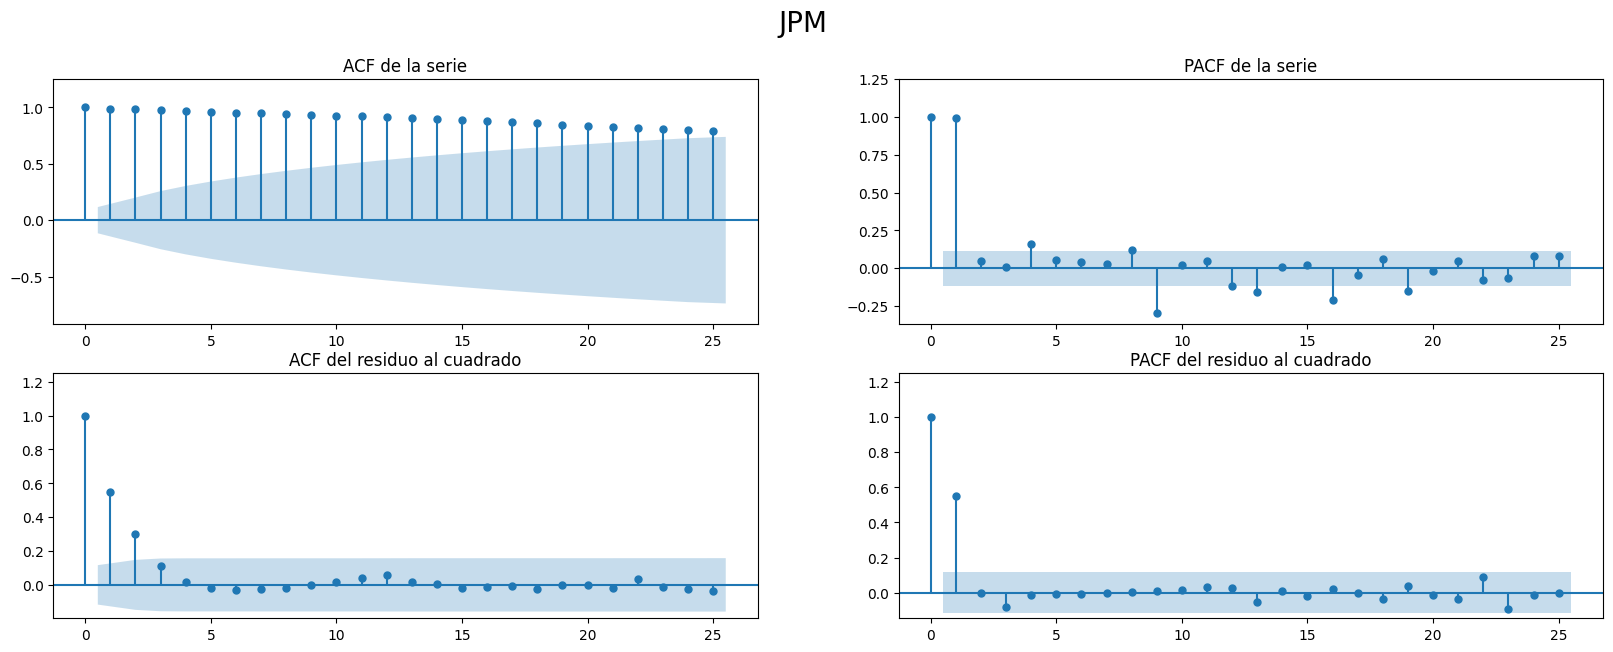

In [44]:
graficos_acf_pacf(df_vol1, "JPM")

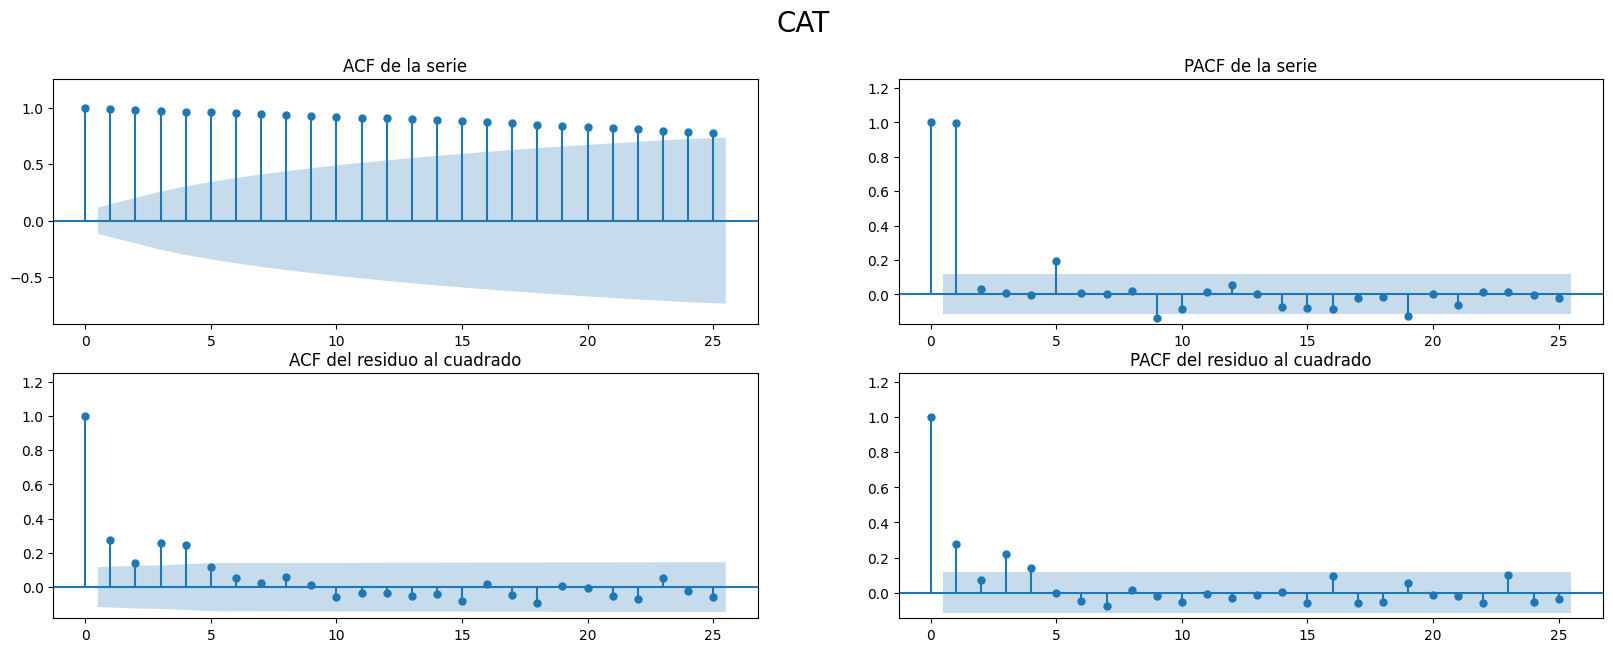

In [45]:
graficos_acf_pacf(df_vol2, "CAT")

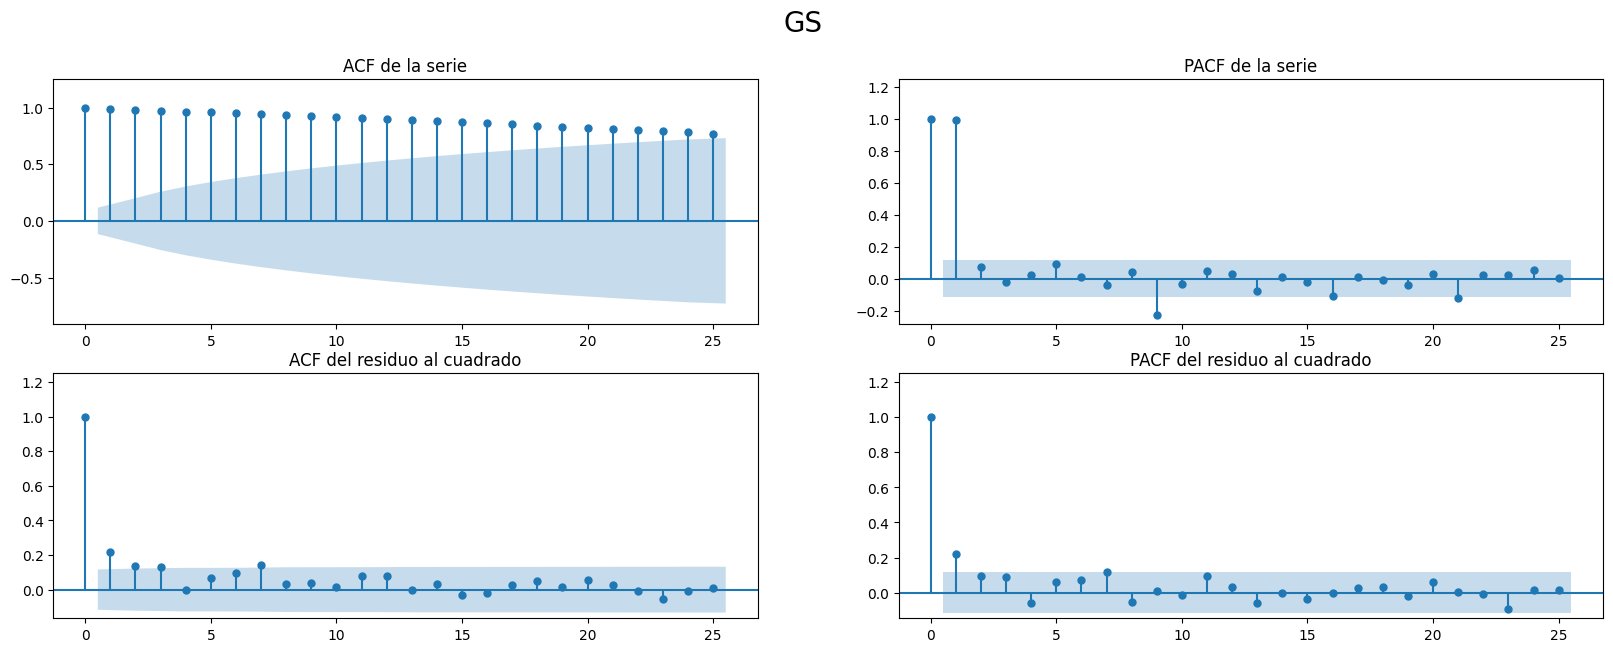

In [46]:
graficos_acf_pacf(df_vol3, "GS")

In [47]:
df_vol3.head()

date     close  close_ret  close_vol   residuo
0  2020-06-01  196.4900        NaN        NaN -6.646374
1  2020-06-02  203.0225   0.033246   0.001105 -2.636955
2  2020-06-03  209.9100   0.033925   0.001151  1.735901
3  2020-06-04  211.3250   0.006741   0.000045  1.219952
4  2020-06-05  219.6500   0.039394   0.001552  5.526735

In [48]:
def volatilidad_anualizada_cartera():
    lista = ['JPM', 'CAT', 'GS']
    lista2 = [0.332834,0.303271,0.301934]
    df_stds = pd.DataFrame({'Empresa': lista, 'Volatilidad': lista2})
    return df_stds
volatilidad_anualizada_cartera()

Empresa  Volatilidad
0     JPM     0.332834
1     CAT     0.303271
2      GS     0.301934

### Modelización de la volatilidad para la serie original

Teniendo en cuenta los resiudos al cuadrado de la serie al cuadrado, lo más probable es q las opciones más interesantes sean los modelos GARCH.

In [49]:
def modelo_arch_resultados(df, test_df, p):
    modelo_arch_ = arch_model(df.residuo, vol="ARCH", p=p, mean="zero")
    resultados_arch = modelo_arch_.fit(last_obs = test_df.index[0])
    return resultados_arch

In [50]:
def modelo_arch_summary(df, test_df, p):
    modelo_arch_ = arch_model(df.residuo, vol="ARCH", p=p, mean="zero")
    resultados_arch = modelo_arch_.fit(last_obs = test_df.index[0])
    return resultados_arch.summary()

In [51]:
def modelo_garch_resultados(df, test_df, p, q):
    modelo_garch_ = arch_model(df.residuo, vol="GARCH", p=p, q=q, mean="zero")
    resultados_garch = modelo_garch_.fit(last_obs = test_df.index[0])
    return resultados_garch

In [52]:
def modelo_garch_summary(df, test_df, p, q):
    modelo_garch_ = arch_model(df.residuo, vol="GARCH", p=p, q=q, mean="zero")
    resultados_garch = modelo_garch_.fit(last_obs = test_df.index[0])
    return resultados_garch.summary()

### JPM

Si el omega no se parece a la desviación original de la serie, convendría utilizar un modelo ARCH

In [53]:
for i in range(1,5):
    for u in range(1,5):
        print(f'GARCH({i},{u})')
        print(modelo_garch_summary(df_vol1, test_df1, p=i, q=u))
        print('\n')

GARCH(1,1)
Iteration:      1,   Func. Count:      5,   Neg. LLF: 126230704.81369393
Iteration:      2,   Func. Count:     11,   Neg. LLF: 539.4373651271663
Iteration:      3,   Func. Count:     16,   Neg. LLF: 502.41462202166326
Iteration:      4,   Func. Count:     21,   Neg. LLF: 496.7595166014885
Iteration:      5,   Func. Count:     26,   Neg. LLF: 496.05303539353054
Iteration:      6,   Func. Count:     30,   Neg. LLF: 496.0481485832322
Iteration:      7,   Func. Count:     34,   Neg. LLF: 496.0467717056572
Iteration:      8,   Func. Count:     38,   Neg. LLF: 496.04573964588235
Iteration:      9,   Func. Count:     42,   Neg. LLF: 496.04568458462836
Iteration:     10,   Func. Count:     46,   Neg. LLF: 496.04568232181134
Iteration:     11,   Func. Count:     49,   Neg. LLF: 496.04568232177724
Optimization terminated successfully    (Exit mode 0)
            Current function value: 496.04568232181134
            Iterations: 11
            Function evaluations: 49
            Gradi

In [54]:
for i in range(1,8):
        print(f'ARCH({i})')
        print(modelo_arch_summary(df_vol1, test_df1, p=i))
        print('\n')

ARCH(1)
Iteration:      1,   Func. Count:      4,   Neg. LLF: 126230704.81369393
Iteration:      2,   Func. Count:      8,   Neg. LLF: 540.3985576301196
Iteration:      3,   Func. Count:     12,   Neg. LLF: 499.37088961728494
Iteration:      4,   Func. Count:     15,   Neg. LLF: 499.3682430581578
Iteration:      5,   Func. Count:     18,   Neg. LLF: 499.36823769148396
Iteration:      6,   Func. Count:     20,   Neg. LLF: 499.36823769145906
Optimization terminated successfully    (Exit mode 0)
            Current function value: 499.36823769148396
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
                        Zero Mean - ARCH Model Results                        
Dep. Variable:                residuo   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.004
Vol Model:                       ARCH   Log-Likelihood:               -499.368
Distribution:                  N

Iteration:      7,   Func. Count:     48,   Neg. LLF: 494.7140554902081
Iteration:      8,   Func. Count:     55,   Neg. LLF: 494.4884715147873
Iteration:      9,   Func. Count:     61,   Neg. LLF: 494.4851707109187
Iteration:     10,   Func. Count:     67,   Neg. LLF: 494.48510556335157
Iteration:     11,   Func. Count:     73,   Neg. LLF: 494.48510420630566
Iteration:     12,   Func. Count:     78,   Neg. LLF: 494.4851045894562
Optimization terminated successfully    (Exit mode 0)
            Current function value: 494.48510420630566
            Iterations: 12
            Function evaluations: 78
            Gradient evaluations: 12
                        Zero Mean - ARCH Model Results                        
Dep. Variable:                residuo   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.004
Vol Model:                       ARCH   Log-Likelihood:               -494.485
Distribution:                  Normal   

* Activo JPM - Modelos dentro del umbral < 0.05

In [55]:
#GARCH(1,1)
resultados_garch11 = modelo_garch_resultados(df_vol1, test_df1, p=1, q=1)

Iteration:      1,   Func. Count:      5,   Neg. LLF: 126230704.81369393
Iteration:      2,   Func. Count:     11,   Neg. LLF: 539.4373651271663
Iteration:      3,   Func. Count:     16,   Neg. LLF: 502.41462202166326
Iteration:      4,   Func. Count:     21,   Neg. LLF: 496.7595166014885
Iteration:      5,   Func. Count:     26,   Neg. LLF: 496.05303539353054
Iteration:      6,   Func. Count:     30,   Neg. LLF: 496.0481485832322
Iteration:      7,   Func. Count:     34,   Neg. LLF: 496.0467717056572
Iteration:      8,   Func. Count:     38,   Neg. LLF: 496.04573964588235
Iteration:      9,   Func. Count:     42,   Neg. LLF: 496.04568458462836
Iteration:     10,   Func. Count:     46,   Neg. LLF: 496.04568232181134
Iteration:     11,   Func. Count:     49,   Neg. LLF: 496.04568232177724
Optimization terminated successfully    (Exit mode 0)
            Current function value: 496.04568232181134
            Iterations: 11
            Function evaluations: 49
            Gradient evaluat

In [56]:
#ARCH(1), ARCH(2), ARCH(3)
resultados_arch1 = modelo_arch_resultados(df_vol1, test_df1, p=1)
resultados_arch2 = modelo_arch_resultados(df_vol1, test_df1, p=2)
resultados_arch3 = modelo_arch_resultados(df_vol1, test_df1, p=3)

Iteration:      1,   Func. Count:      4,   Neg. LLF: 126230704.81369393
Iteration:      2,   Func. Count:      8,   Neg. LLF: 540.3985576301196
Iteration:      3,   Func. Count:     12,   Neg. LLF: 499.37088961728494
Iteration:      4,   Func. Count:     15,   Neg. LLF: 499.3682430581578
Iteration:      5,   Func. Count:     18,   Neg. LLF: 499.36823769148396
Iteration:      6,   Func. Count:     20,   Neg. LLF: 499.36823769145906
Optimization terminated successfully    (Exit mode 0)
            Current function value: 499.36823769148396
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: 126230704.81369393
Iteration:      2,   Func. Count:     11,   Neg. LLF: 575.1456717767988
Iteration:      3,   Func. Count:     16,   Neg. LLF: 499.7614699045324
Iteration:      4,   Func. Count:     21,   Neg. LLF: 496.911823744808
Iteration:      5,   Func. Count:     26,   Neg. LLF: 496.3423656888

La importancia de que los valores P>|t| sean menores que 0.05 radica en la inferencia estadística. Cuando los valores P>|t| son bajos, se asume que el coeficiente correspondiente es significativo y que el término asociado tiene un impacto importante en el modelo. Por lo tanto, se concluye que el coeficiente no es igual a cero, lo que es una señal de que hay evidencia suficiente para respaldar su inclusión en el modelo

* Activo JPM - Modelos fuera del umbral < 0.05

GARCH (2,1), (1,4), (2,1)

In [57]:
#GARCH(2,1), GARCH(2,1)
resultados_garch12 = modelo_garch_resultados(df_vol1, test_df1, p=1, q=2)
resultados_garch21 = modelo_garch_resultados(df_vol1, test_df1, p=2, q=1)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 126230704.81369393
Iteration:      2,   Func. Count:     13,   Neg. LLF: 537.8807961992943
Iteration:      3,   Func. Count:     19,   Neg. LLF: 502.69314614116604
Iteration:      4,   Func. Count:     25,   Neg. LLF: 496.0906089620016
Iteration:      5,   Func. Count:     30,   Neg. LLF: 496.70352562143063
Iteration:      6,   Func. Count:     36,   Neg. LLF: 496.0624167214444
Iteration:      7,   Func. Count:     41,   Neg. LLF: 496.04777140049663
Iteration:      8,   Func. Count:     46,   Neg. LLF: 496.0462918340081
Iteration:      9,   Func. Count:     51,   Neg. LLF: 496.0456823858625
Iteration:     10,   Func. Count:     55,   Neg. LLF: 496.0456824746105
Optimization terminated successfully    (Exit mode 0)
            Current function value: 496.0456823858625
            Iterations: 10
            Function evaluations: 55
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 69517.6780247

### Predicción de la volatilidad

In [58]:
predictions_df = test_df1.copy()

predictions_df["Predictions_GARCH11"] = resultados_garch11.forecast().residual_variance.loc[test_df1.index]
predictions_df["Predictions_ARCH1"] = resultados_arch1.forecast().residual_variance.loc[test_df1.index]
predictions_df["Predictions_ARCH2"] = resultados_arch2.forecast().residual_variance.loc[test_df1.index]
predictions_df["Predictions_ARCH3"] = resultados_arch3.forecast().residual_variance.loc[test_df1.index]
predictions_df["Predictions_GARCH12"] = resultados_garch12.forecast().residual_variance.loc[test_df1.index]
predictions_df["Predictions_GARCH21"] = resultados_garch21.forecast().residual_variance.loc[test_df1.index]


c:\Users\uxueu\.conda\envs\reto9_bbva\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


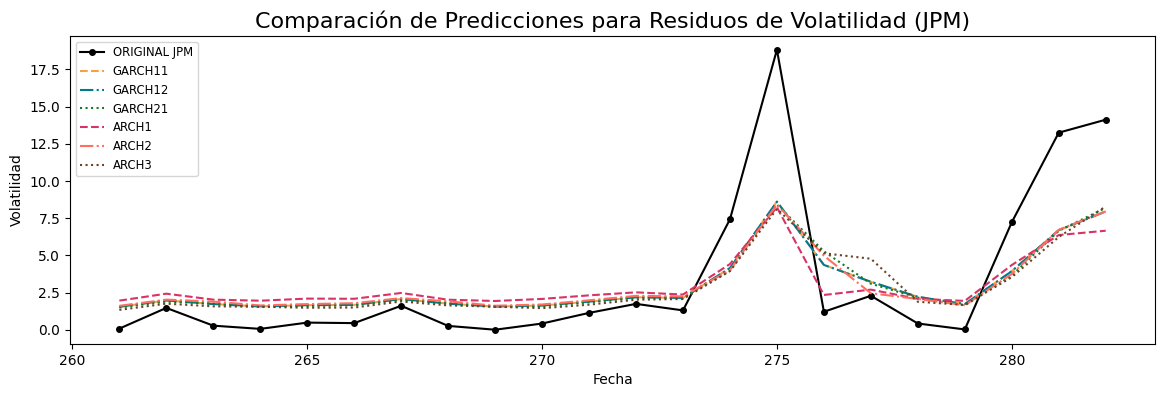

In [59]:
plt.figure(figsize=(14, 4))

vol_prediction = test_df1.residuo.mul(test_df1.residuo)
plt.plot(vol_prediction, label="ORIGINAL JPM", linestyle='-', marker='o', markersize=4, color='black')  # Negro
models = ["GARCH11", "GARCH12", "GARCH21", "ARCH1", "ARCH2", "ARCH3"]
colors = ['#F89F41', '#007A92', '#127B24', '#D83367', '#FF6F61', '#6B4226']  # Paleta de colores
linestyles = ['--', '-.', ':', '--', '-.', ':']

for i, model in enumerate(models):
    plt.plot(predictions_df[f"Predictions_{model}"], label=model, linestyle=linestyles[i], color=colors[i])

plt.title("Comparación de Predicciones para Residuos de Volatilidad (JPM)", size=16, color='black')  # Negro
plt.xlabel("Fecha")
plt.ylabel("Volatilidad")
plt.grid(True)
plt.legend(loc='best', fontsize='small')
plt.gca().xaxis.grid(False)
plt.gca().yaxis.grid(False)
plt.show()


In [60]:
print("RMSE ARCH(1)",np.sqrt(mean_squared_error(vol_prediction, predictions_df["Predictions_ARCH1"])))
print("RMSE ARCH(2)",np.sqrt(mean_squared_error(vol_prediction, predictions_df["Predictions_ARCH2"])))
print("RMSE ARCH(3)",np.sqrt(mean_squared_error(vol_prediction, predictions_df["Predictions_ARCH3"])))
print("RMSE GARCH(1,1)",np.sqrt(mean_squared_error(vol_prediction, predictions_df["Predictions_GARCH11"])))
print("RMSE GARCH(1,2)",np.sqrt(mean_squared_error(vol_prediction, predictions_df["Predictions_GARCH12"])))
print("RMSE GARCH(2,1)",np.sqrt(mean_squared_error(vol_prediction, predictions_df["Predictions_GARCH21"])))

RMSE ARCH(1) 3.5030308368123233
RMSE ARCH(2) 3.3842772663456513
RMSE ARCH(3) 3.4618189257986582
RMSE GARCH(1,1) 3.3094577341143245
RMSE GARCH(1,2) 3.3093116248942556
RMSE GARCH(2,1) 3.3797568971161596


### CAT

In [61]:
for i in range(1,5):
    for u in range(1,5):
        print(f'GARCH({i},{u})')
        print(modelo_garch_summary(df_vol2, test_df2, p=i, q=u))
        print('\n')

GARCH(1,1)
Iteration:      1,   Func. Count:      5,   Neg. LLF: 502181.8912108262
Iteration:      2,   Func. Count:     10,   Neg. LLF: 606.5364408038126
Iteration:      3,   Func. Count:     15,   Neg. LLF: 893.8031879437394
Iteration:      4,   Func. Count:     21,   Neg. LLF: 598.5664463819538
Iteration:      5,   Func. Count:     26,   Neg. LLF: 584.2945236358842
Iteration:      6,   Func. Count:     30,   Neg. LLF: 584.2941375515757
Iteration:      7,   Func. Count:     34,   Neg. LLF: 584.294134130136
Iteration:      8,   Func. Count:     37,   Neg. LLF: 584.294134130126
Optimization terminated successfully    (Exit mode 0)
            Current function value: 584.294134130136
            Iterations: 8
            Function evaluations: 37
            Gradient evaluations: 8
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                residuo   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squa

Iteration:      2,   Func. Count:     12,   Neg. LLF: 124346861.00889248
Iteration:      3,   Func. Count:     19,   Neg. LLF: 602.7921639632905
Iteration:      4,   Func. Count:     25,   Neg. LLF: 586.3439962557264
Iteration:      5,   Func. Count:     31,   Neg. LLF: 584.3133930839277
Iteration:      6,   Func. Count:     36,   Neg. LLF: 584.3024365363968
Iteration:      7,   Func. Count:     41,   Neg. LLF: 584.3052731053698
Iteration:      8,   Func. Count:     47,   Neg. LLF: 584.2941389587004
Iteration:      9,   Func. Count:     52,   Neg. LLF: 584.2941346675117
Iteration:     10,   Func. Count:     57,   Neg. LLF: 584.2941341311163
Optimization terminated successfully    (Exit mode 0)
            Current function value: 584.2941341311163
            Iterations: 10
            Function evaluations: 57
            Gradient evaluations: 10
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                residuo   R-squared:             

In [62]:
for i in range(1,8):
        print(f'ARCH({i})')
        print(modelo_arch_summary(df_vol2, test_df2, p=i))
        print('\n')

ARCH(1)
Iteration:      1,   Func. Count:      4,   Neg. LLF: 598.9188608475564
Iteration:      2,   Func. Count:      9,   Neg. LLF: 589.5573114669749
Iteration:      3,   Func. Count:     13,   Neg. LLF: 589.453241555672
Iteration:      4,   Func. Count:     15,   Neg. LLF: 589.45324155574
Optimization terminated successfully    (Exit mode 0)
            Current function value: 589.453241555672
            Iterations: 4
            Function evaluations: 15
            Gradient evaluations: 4
                        Zero Mean - ARCH Model Results                        
Dep. Variable:                residuo   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.004
Vol Model:                       ARCH   Log-Likelihood:               -589.453
Distribution:                  Normal   AIC:                           1182.91
Method:            Maximum Likelihood   BIC:                           1190.04
                           

Iteration:      4,   Func. Count:     25,   Neg. LLF: 583.1348441230031
Iteration:      5,   Func. Count:     31,   Neg. LLF: 582.6204484460134
Iteration:      6,   Func. Count:     37,   Neg. LLF: 587.7315640900952
Iteration:      7,   Func. Count:     43,   Neg. LLF: 581.8080137658985
Iteration:      8,   Func. Count:     48,   Neg. LLF: 581.8077776091927
Iteration:      9,   Func. Count:     53,   Neg. LLF: 581.8077704035516
Iteration:     10,   Func. Count:     57,   Neg. LLF: 581.8077704035397
Optimization terminated successfully    (Exit mode 0)
            Current function value: 581.8077704035516
            Iterations: 10
            Function evaluations: 57
            Gradient evaluations: 10
                        Zero Mean - ARCH Model Results                        
Dep. Variable:                residuo   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.004
Vol Model:                       ARCH   Log-Likeli

* Activo CAT - Modelos dentro del umbral < 0.05

In [63]:
#GARCH(1,1)
resultados_garch11 = modelo_garch_resultados(df_vol2, test_df2, p=1, q=1)

Iteration:      1,   Func. Count:      5,   Neg. LLF: 502181.8912108262
Iteration:      2,   Func. Count:     10,   Neg. LLF: 606.5364408038126
Iteration:      3,   Func. Count:     15,   Neg. LLF: 893.8031879437394
Iteration:      4,   Func. Count:     21,   Neg. LLF: 598.5664463819538
Iteration:      5,   Func. Count:     26,   Neg. LLF: 584.2945236358842
Iteration:      6,   Func. Count:     30,   Neg. LLF: 584.2941375515757
Iteration:      7,   Func. Count:     34,   Neg. LLF: 584.294134130136
Iteration:      8,   Func. Count:     37,   Neg. LLF: 584.294134130126
Optimization terminated successfully    (Exit mode 0)
            Current function value: 584.294134130136
            Iterations: 8
            Function evaluations: 37
            Gradient evaluations: 8


In [64]:
#ARCH(1), ARCH(2), ARCH(3)
resultados_arch1 = modelo_arch_resultados(df_vol2, test_df2, p=1)
resultados_arch2 = modelo_arch_resultados(df_vol2, test_df2, p=2)
resultados_arch3 = modelo_arch_resultados(df_vol2, test_df2, p=3)

Iteration:      1,   Func. Count:      4,   Neg. LLF: 598.9188608475564
Iteration:      2,   Func. Count:      9,   Neg. LLF: 589.5573114669749
Iteration:      3,   Func. Count:     13,   Neg. LLF: 589.453241555672
Iteration:      4,   Func. Count:     15,   Neg. LLF: 589.45324155574
Optimization terminated successfully    (Exit mode 0)
            Current function value: 589.453241555672
            Iterations: 4
            Function evaluations: 15
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      5,   Neg. LLF: 596.5184370385402
Iteration:      2,   Func. Count:     10,   Neg. LLF: 604.4808199878555
Iteration:      3,   Func. Count:     15,   Neg. LLF: 589.5190883379506
Iteration:      4,   Func. Count:     20,   Neg. LLF: 714.623403518665
Iteration:      5,   Func. Count:     25,   Neg. LLF: 587.2996699851594
Iteration:      6,   Func. Count:     29,   Neg. LLF: 587.2788445079061
Iteration:      7,   Func. Count:     33,   Neg. LLF: 587.2785955205926
Iterat

* Activo CAT - Modelos fuera del umbral < 0.05

In [65]:
#GARCH(1,2), GARCH(2,1)
resultados_garch12 = modelo_garch_resultados(df_vol2, test_df2, p=1, q=2)
resultados_garch21 = modelo_garch_resultados(df_vol2, test_df2, p=2, q=1)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 502181.8907446894
Iteration:      2,   Func. Count:     12,   Neg. LLF: 803.7171874538896
Iteration:      3,   Func. Count:     19,   Neg. LLF: 616.3844302686632
Iteration:      4,   Func. Count:     25,   Neg. LLF: 590.4225892878533
Iteration:      5,   Func. Count:     31,   Neg. LLF: 584.1896971495623
Iteration:      6,   Func. Count:     37,   Neg. LLF: 585.8212022487608
Iteration:      7,   Func. Count:     43,   Neg. LLF: 584.0611882715502
Iteration:      8,   Func. Count:     48,   Neg. LLF: 584.0611308555174
Iteration:      9,   Func. Count:     52,   Neg. LLF: 584.0611308555507
Optimization terminated successfully    (Exit mode 0)
            Current function value: 584.0611308555174
            Iterations: 9
            Function evaluations: 52
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      6,   Neg. LLF: 502181.89121047466
Iteration:      2,   Func. Count:     12,   Neg. LLF: 124346861.00889248

In [66]:
predictions_df = test_df2.copy()

predictions_df["Predictions_GARCH11"] = resultados_garch11.forecast().residual_variance.loc[test_df2.index]
predictions_df["Predictions_ARCH1"] = resultados_arch1.forecast().residual_variance.loc[test_df2.index]
predictions_df["Predictions_ARCH2"] = resultados_arch2.forecast().residual_variance.loc[test_df2.index]
predictions_df["Predictions_ARCH3"] = resultados_arch3.forecast().residual_variance.loc[test_df2.index]
predictions_df["Predictions_GARCH12"] = resultados_garch12.forecast().residual_variance.loc[test_df2.index]
predictions_df["Predictions_GARCH21"] = resultados_garch21.forecast().residual_variance.loc[test_df2.index]

c:\Users\uxueu\.conda\envs\reto9_bbva\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


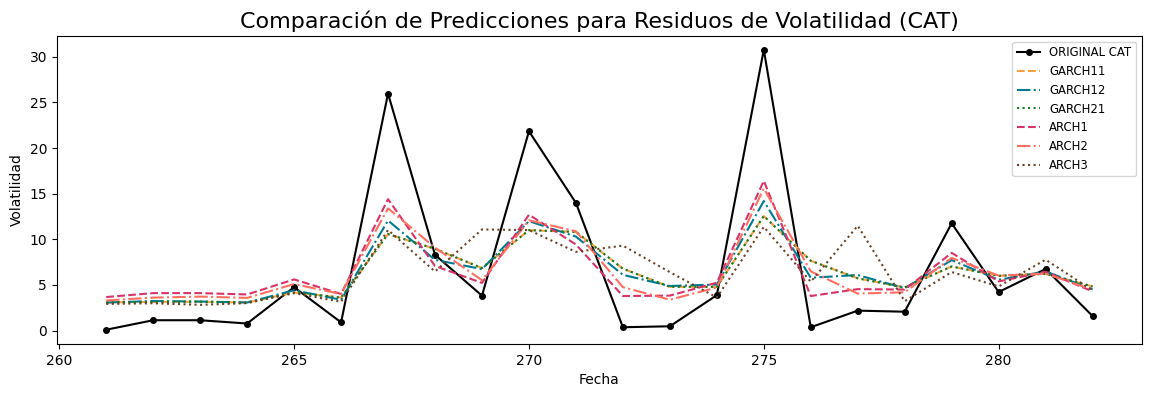

In [67]:
plt.figure(figsize=(14, 4))

vol_prediction = test_df2.residuo.mul(test_df2.residuo)
plt.plot(vol_prediction, label="ORIGINAL CAT", linestyle='-', marker='o', markersize=4, color='black')  # Negro
models = ["GARCH11", "GARCH12", "GARCH21", "ARCH1", "ARCH2", "ARCH3"]
colors = ['#F89F41', '#007A92', '#127B24', '#D83367', '#FF6F61', '#6B4226']  # Paleta de colores
linestyles = ['--', '-.', ':', '--', '-.', ':']

for i, model in enumerate(models):
    plt.plot(predictions_df[f"Predictions_{model}"], label=model, linestyle=linestyles[i], color=colors[i])

plt.title("Comparación de Predicciones para Residuos de Volatilidad (CAT)", size=16, color='black')  # Negro
plt.xlabel("Fecha")
plt.ylabel("Volatilidad")
plt.grid(True)
plt.legend(loc='best', fontsize='small')
plt.gca().xaxis.grid(False)
plt.gca().yaxis.grid(False)
plt.show()

In [68]:
print("RMSE ARCH(1)",np.sqrt(mean_squared_error(vol_prediction, predictions_df["Predictions_ARCH1"])))
print("RMSE ARCH(2)",np.sqrt(mean_squared_error(vol_prediction, predictions_df["Predictions_ARCH2"])))
print("RMSE ARCH(3)",np.sqrt(mean_squared_error(vol_prediction, predictions_df["Predictions_ARCH3"])))
print("RMSE GARCH(1,1)",np.sqrt(mean_squared_error(vol_prediction, predictions_df["Predictions_GARCH11"])))
print("RMSE GARCH(1,2)",np.sqrt(mean_squared_error(vol_prediction, predictions_df["Predictions_GARCH12"])))
print("RMSE GARCH(2,1)",np.sqrt(mean_squared_error(vol_prediction, predictions_df["Predictions_GARCH21"])))

RMSE ARCH(1) 5.072372355943025
RMSE ARCH(2) 5.3849926148518685
RMSE ARCH(3) 7.045399976050418
RMSE GARCH(1,1) 6.416026579886086
RMSE GARCH(1,2) 5.831389960415676
RMSE GARCH(2,1) 6.415984624962983


### GS

In [69]:
for i in range(1,5):
    for u in range(1,5):
        print(f'GARCH({i},{u})')
        print(modelo_garch_summary(df_vol3, test_df3, p=i, q=u))
        print('\n')

GARCH(1,1)
Iteration:      1,   Func. Count:      5,   Neg. LLF: 137223551.97346073
Iteration:      2,   Func. Count:     11,   Neg. LLF: 837.4811646154296
Iteration:      3,   Func. Count:     17,   Neg. LLF: 688.3544938089574
Iteration:      4,   Func. Count:     21,   Neg. LLF: 688.3249266336758
Iteration:      5,   Func. Count:     25,   Neg. LLF: 688.3243014222735
Iteration:      6,   Func. Count:     29,   Neg. LLF: 688.3242064568749
Iteration:      7,   Func. Count:     32,   Neg. LLF: 688.3242064566057
Optimization terminated successfully    (Exit mode 0)
            Current function value: 688.3242064568749
            Iterations: 7
            Function evaluations: 32
            Gradient evaluations: 7
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                residuo   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.004
Vol Model:                      GARCH   

In [70]:
for i in range(1,8):
        print(f'ARCH({i})')
        print(modelo_arch_summary(df_vol3, test_df3, p=i))
        print('\n')

ARCH(1)
Iteration:      1,   Func. Count:      4,   Neg. LLF: 707.325244802675
Iteration:      2,   Func. Count:      9,   Neg. LLF: 693.1088381757743
Iteration:      3,   Func. Count:     12,   Neg. LLF: 693.1066768359401
Iteration:      4,   Func. Count:     15,   Neg. LLF: 693.1066710700906
Iteration:      5,   Func. Count:     17,   Neg. LLF: 693.1066710700686
Optimization terminated successfully    (Exit mode 0)
            Current function value: 693.1066710700906
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
                        Zero Mean - ARCH Model Results                        
Dep. Variable:                residuo   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.004
Vol Model:                       ARCH   Log-Likelihood:               -693.107
Distribution:                  Normal   AIC:                           1390.21
Method:            Maximum Like

Iteration:      1,   Func. Count:      6,   Neg. LLF: 702.312765954438
Iteration:      2,   Func. Count:     13,   Neg. LLF: 696.5732482380911
Iteration:      3,   Func. Count:     19,   Neg. LLF: 690.3408535524511
Iteration:      4,   Func. Count:     26,   Neg. LLF: 695.7213850330552
Iteration:      5,   Func. Count:     33,   Neg. LLF: 686.3692089572448
Iteration:      6,   Func. Count:     38,   Neg. LLF: 686.3688681291474
Iteration:      7,   Func. Count:     43,   Neg. LLF: 686.3688674498101
Optimization terminated successfully    (Exit mode 0)
            Current function value: 686.3688674498101
            Iterations: 7
            Function evaluations: 43
            Gradient evaluations: 7
                        Zero Mean - ARCH Model Results                        
Dep. Variable:                residuo   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.004
Vol Model:                       ARCH   Log-Likelihoo

* Activo GS - Modelos dentro del umbral < 0.05

In [71]:
#ARCH(1), ARCH(2)
resultados_arch1 = modelo_arch_resultados(df_vol3, test_df3, p=1)
resultados_arch2 = modelo_arch_resultados(df_vol3, test_df3, p=2)

Iteration:      1,   Func. Count:      4,   Neg. LLF: 707.325244802675
Iteration:      2,   Func. Count:      9,   Neg. LLF: 693.1088381757743
Iteration:      3,   Func. Count:     12,   Neg. LLF: 693.1066768359401
Iteration:      4,   Func. Count:     15,   Neg. LLF: 693.1066710700906
Iteration:      5,   Func. Count:     17,   Neg. LLF: 693.1066710700686
Optimization terminated successfully    (Exit mode 0)
            Current function value: 693.1066710700906
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      5,   Neg. LLF: 705.2603361723686
Iteration:      2,   Func. Count:     11,   Neg. LLF: 694.8605609896974
Iteration:      3,   Func. Count:     17,   Neg. LLF: 690.4618597865988
Iteration:      4,   Func. Count:     21,   Neg. LLF: 690.4618591292134
Optimization terminated successfully    (Exit mode 0)
            Current function value: 690.4618591292134
            Iterations: 4
            

* Activo GS - Modelos fuera del umbral < 0.05

In [72]:
# GARCH(1,1), GARCH(1,2), GARCH(1,3), GARCH(1,4)
resultados_garch11 = modelo_garch_resultados(df_vol3, test_df3, p=1, q=1)
resultados_garch12 = modelo_garch_resultados(df_vol3, test_df3, p=1, q=2)
resultados_garch13 = modelo_garch_resultados(df_vol3, test_df3, p=1, q=3)
resultados_garch14 = modelo_garch_resultados(df_vol3, test_df3, p=1, q=4)

Iteration:      1,   Func. Count:      5,   Neg. LLF: 137223551.97346073
Iteration:      2,   Func. Count:     11,   Neg. LLF: 837.4811646154296
Iteration:      3,   Func. Count:     17,   Neg. LLF: 688.3544938089574
Iteration:      4,   Func. Count:     21,   Neg. LLF: 688.3249266336758
Iteration:      5,   Func. Count:     25,   Neg. LLF: 688.3243014222735
Iteration:      6,   Func. Count:     29,   Neg. LLF: 688.3242064568749
Iteration:      7,   Func. Count:     32,   Neg. LLF: 688.3242064566057
Optimization terminated successfully    (Exit mode 0)
            Current function value: 688.3242064568749
            Iterations: 7
            Function evaluations: 32
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      6,   Neg. LLF: 952.0453911127485
Iteration:      2,   Func. Count:     13,   Neg. LLF: 702.9292431229605
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1683.513768571024
Iteration:      4,   Func. Count:     26,   Neg. LLF: 688.5517674422745


In [73]:
predictions_df = test_df3.copy()

predictions_df["Predictions_ARCH1"] = resultados_arch1.forecast().residual_variance.loc[test_df3.index]
predictions_df["Predictions_ARCH2"] = resultados_arch2.forecast().residual_variance.loc[test_df3.index]
predictions_df["Predictions_GARCH12"] = resultados_garch12.forecast().residual_variance.loc[test_df3.index]
predictions_df["Predictions_GARCH11"] = resultados_garch11.forecast().residual_variance.loc[test_df3.index]
predictions_df["Predictions_GARCH13"] = resultados_garch13.forecast().residual_variance.loc[test_df3.index]
predictions_df["Predictions_GARCH14"] = resultados_garch14.forecast().residual_variance.loc[test_df3.index]

c:\Users\uxueu\.conda\envs\reto9_bbva\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


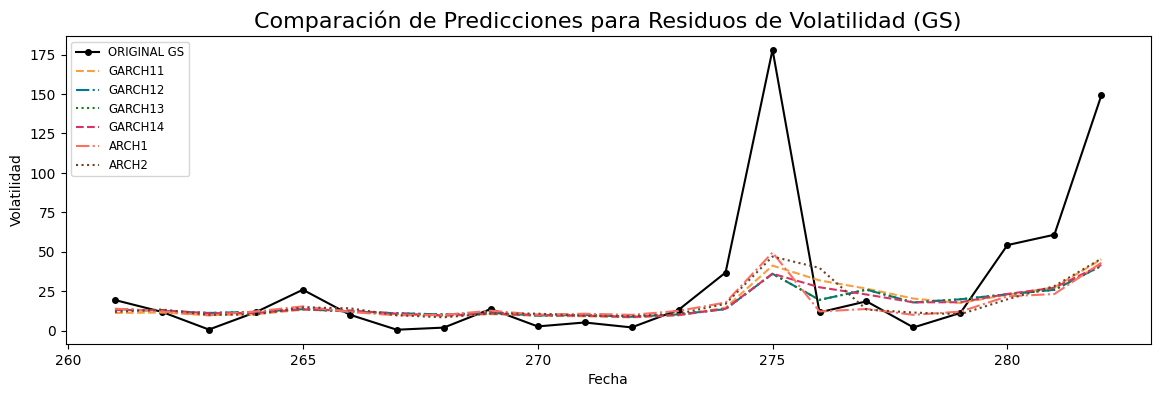

In [74]:
plt.figure(figsize=(14, 4))

vol_prediction = test_df3.residuo.mul(test_df3.residuo)
plt.plot(vol_prediction, label="ORIGINAL GS", linestyle='-', marker='o', markersize=4, color='black')  # Negro
models = ["GARCH11", "GARCH12", "GARCH13", "GARCH14","ARCH1", "ARCH2"]
colors = ['#F89F41', '#007A92', '#127B24', '#D83367', '#FF6F61', '#6B4226']  # Paleta de colores
linestyles = ['--', '-.', ':', '--', '-.', ':']

for i, model in enumerate(models):
    plt.plot(predictions_df[f"Predictions_{model}"], label=model, linestyle=linestyles[i], color=colors[i])

plt.title("Comparación de Predicciones para Residuos de Volatilidad (GS)", size=16, color='black')  # Negro
plt.xlabel("Fecha")
plt.ylabel("Volatilidad")
plt.grid(True)
plt.legend(loc='best', fontsize='small')
plt.gca().xaxis.grid(False)
plt.gca().yaxis.grid(False)
plt.show()

In [75]:
print("RMSE ARCH(1)",np.sqrt(mean_squared_error(vol_prediction, predictions_df["Predictions_ARCH1"])))
print("RMSE ARCH(2)",np.sqrt(mean_squared_error(vol_prediction, predictions_df["Predictions_ARCH2"])))
print("RMSE GARCH(1,1)",np.sqrt(mean_squared_error(vol_prediction, predictions_df["Predictions_GARCH11"])))
print("RMSE GARCH(1,2)",np.sqrt(mean_squared_error(vol_prediction, predictions_df["Predictions_GARCH12"])))
print("RMSE GARCH(1,3)",np.sqrt(mean_squared_error(vol_prediction, predictions_df["Predictions_GARCH13"])))
print("RMSE GARCH(1,4)",np.sqrt(mean_squared_error(vol_prediction, predictions_df["Predictions_GARCH14"])))

RMSE ARCH(1) 37.6727592829867
RMSE ARCH(2) 38.145218730079506
RMSE GARCH(1,1) 39.06665097703474
RMSE GARCH(1,2) 40.24503566319541
RMSE GARCH(1,3) 40.24397957898986
RMSE GARCH(1,4) 40.1724512872329
